In [25]:
!nvidia-smi

Sat Jun 28 20:11:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti     On  |   00000000:01:00.0  On |                  N/A |
|  0%   42C    P8             11W /  285W |    1752MiB /  12282MiB |     31%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [26]:
import warnings ; warnings.filterwarnings('ignore')

import itertools
import gym, gym_walk, gym_aima
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm_notebook as tqdm
from mpl_toolkits.mplot3d import Axes3D

from itertools import cycle, count

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [27]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [28]:
def value_iteration(P, gamma=1.0, theta=1e-10):
    V = np.zeros(len(P), dtype=np.float64)
    while True:
        Q = np.zeros((len(P), len(P[0])), dtype=np.float64)
        for s in range(len(P)):
            for a in range(len(P[s])):
                for prob, next_state, reward, done in P[s][a]:
                    Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))
        if np.max(np.abs(V - np.max(Q, axis=1))) < theta:
            break
        V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi

In [29]:
def print_policy(pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
    print(title)
    arrs = {k:v for k,v in enumerate(action_symbols)}
    for s in range(len(P)):
        a = pi(s)
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), arrs[a].rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [30]:
def print_state_value_function(V, P, n_cols=4, prec=3, title='State-value function:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{}'.format(np.round(v, prec)).rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [31]:
def print_action_value_function(Q, 
                                optimal_Q=None, 
                                action_symbols=('<', '>'), 
                                prec=3, 
                                title='Action-value function:'):
    vf_types=('',) if optimal_Q is None else ('', '*', 'err')
    headers = ['s',] + [' '.join(i) for i in list(itertools.product(vf_types, action_symbols))]
    print(title)
    states = np.arange(len(Q))[..., np.newaxis]
    arr = np.hstack((states, np.round(Q, prec)))
    if not (optimal_Q is None):
        arr = np.hstack((arr, np.round(optimal_Q, prec), np.round(optimal_Q-Q, prec)))
    print(tabulate(arr, headers, tablefmt="fancy_grid"))

In [32]:
def get_policy_metrics(env, gamma, pi, goal_state, optimal_Q, 
                       n_episodes=100, max_steps=200):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    reached_goal, episode_reward, episode_regret = [], [], []
    for _ in range(n_episodes):
        state, done, steps = env.reset(), False, 0
        episode_reward.append(0.0)
        episode_regret.append(0.0)
        while not done and steps < max_steps:
            action = pi(state)
            regret = np.max(optimal_Q[state]) - optimal_Q[state][action]
            episode_regret[-1] += regret
            
            state, reward, done, _ = env.step(action)
            episode_reward[-1] += (gamma**steps * reward)
            
            steps += 1

        reached_goal.append(state == goal_state)
    results = np.array((np.sum(reached_goal)/len(reached_goal)*100, 
                        np.mean(episode_reward), 
                        np.mean(episode_regret)))
    return results

In [33]:
def get_metrics_from_tracks(env, gamma, goal_state, optimal_Q, pi_track, coverage=0.1):
    total_samples = len(pi_track)
    n_samples = int(total_samples * coverage)
    samples_e = np.linspace(0, total_samples, n_samples, endpoint=True, dtype=np.int)
    metrics = []
    for e, pi in enumerate(tqdm(pi_track)):
        if e in samples_e:
            metrics.append(get_policy_metrics(
                env, 
                gamma=gamma, 
                pi=lambda s: pi[s], 
                goal_state=goal_state, 
                optimal_Q=optimal_Q))
        else:
            metrics.append(metrics[-1])
    metrics = np.array(metrics)
    success_rate_ma, mean_return_ma, mean_regret_ma = np.apply_along_axis(moving_average, axis=0, arr=metrics).T
    return success_rate_ma, mean_return_ma, mean_regret_ma

In [34]:
def rmse(x, y, dp=4):
    return np.round(np.sqrt(np.mean((x - y)**2)), dp)

In [35]:
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [36]:
def plot_value_function(title, V_track, V_true=None, log=False, limit_value=0.05, limit_items=5):
    np.random.seed(123)
    per_col = 25
    linecycler = cycle(["-","--",":","-."])
    legends = []

    valid_values = np.argwhere(V_track[-1] > limit_value).squeeze()
    items_idxs = np.random.choice(valid_values, 
                                  min(len(valid_values), limit_items), 
                                  replace=False)
    # draw the true values first
    if V_true is not None:
        for i, state in enumerate(V_track.T):
            if i not in items_idxs:
                continue
            if state[-1] < limit_value:
                continue

            label = 'v*({})'.format(i)
            plt.axhline(y=V_true[i], color='k', linestyle='-', linewidth=1)
            plt.text(int(len(V_track)*1.02), V_true[i]+.01, label)

    # then the estimates
    for i, state in enumerate(V_track.T):
        if i not in items_idxs:
            continue
        if state[-1] < limit_value:
            continue
        line_type = next(linecycler)
        label = 'V({})'.format(i)
        p, = plt.plot(state, line_type, label=label, linewidth=3)
        legends.append(p)
        
    legends.reverse()

    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx+per_col]
        l = plt.legend(subset, [p.get_label() for p in subset], 
                       loc='center right', bbox_to_anchor=(1.25, 0.5))
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    if log: plt.xscale('log')
    plt.title(title)
    plt.ylabel('State-value function')
    plt.xlabel('Episodes (log scale)' if log else 'Episodes')
    plt.show()

In [37]:
def plot_transition_model(T_track, episode = 0):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=20, azim=50)

    color_left = '#008fd5' # ax._get_lines.get_next_color()
    color_right = '#fc4f30' #ax._get_lines.get_next_color()

    left_prob = np.divide(T_track[episode][:,0].T, 
                          T_track[episode][:,0].sum(axis=1).T).T
    left_prob = np.nan_to_num(left_prob, 0)

    right_prob = np.divide(T_track[episode][:,1].T, 
                           T_track[episode][:,1].sum(axis=1).T).T
    right_prob = np.nan_to_num(right_prob, 0)

    for s in np.arange(9):
        ax.bar3d(s+0.1, np.arange(9)+0.1, np.zeros(9),
                 np.zeros(9)+0.3,
                 np.zeros(9)+0.3, 
                 left_prob[s], 
                 color=color_left, 
                 alpha=0.75,
                 shade=True)
        ax.bar3d(s+0.1, np.arange(9)+0.1, left_prob[s],
                 np.zeros(9)+0.3,
                 np.zeros(9)+0.3, 
                 right_prob[s], 
                 color=color_right, 
                 alpha=0.75,
                 shade=True)

    ax.tick_params(axis='x', which='major', pad=10)
    ax.tick_params(axis='y', which='major', pad=10)
    ax.tick_params(axis='z', which='major', pad=10)

    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xticks(np.arange(9))
    ax.set_yticks(np.arange(9))

    plt.title('SWS learned MDP after {} episodes'.format(episode+1))
    ax.set_xlabel('Initial\nstate', labelpad=75, rotation=0)
    ax.set_ylabel('Landing\nstate', labelpad=75, rotation=0)
    ax.set_zlabel('Transition\nprobabilities', labelpad=75, rotation=0)

    left_proxy = plt.Rectangle((0, 0), 1, 1, fc=color_left)
    right_proxy = plt.Rectangle((0, 0), 1, 1, fc=color_right)

    plt.legend((left_proxy, right_proxy), 
               ('Left', 'Right'), 
               bbox_to_anchor=(0.15, 0.9), 
               borderaxespad=0.)

    ax.dist = 12
    #plt.gcf().subplots_adjust(left=0.1, right=0.9)
    plt.tight_layout()

    plt.show()

In [38]:
def plot_model_state_sampling(planning, algo='Dyna-Q'):
    fig = plt.figure(figsize=(20,10))

    color_left = '#008fd5' # ax._get_lines.get_next_color()
    color_right = '#fc4f30' #ax._get_lines.get_next_color()

    for s in np.arange(9):
        actions = planning[np.where(planning[:,0]==s)[0], 1]
        left = len(actions[actions == 0])
        right = len(actions[actions == 1])
        plt.bar(s, right, 0.2, color=color_right)
        plt.bar(s, left, 0.2, color=color_left, bottom=right)


    plt.title('States samples from {}\nlearned model of SWS environment'.format(algo))
    plt.xticks(range(9))
    plt.xlabel('Initial states sampled', labelpad=20)
    plt.ylabel('Count', labelpad=50, rotation=0)

    left_proxy = plt.Rectangle((0, 0), 1, 1, fc=color_left)
    right_proxy = plt.Rectangle((0, 0), 1, 1, fc=color_right)

    plt.legend((left_proxy, right_proxy), 
               ('Left', 'Right'), 
               bbox_to_anchor=(0.99, 1.1), 
               borderaxespad=0.)

    #plt.gcf().subplots_adjust(left=0.1, right=0.9)
    plt.tight_layout()

    plt.show()

In [39]:
def plot_model_state_7(planning, algo='Dyna-Q'):
    fig = plt.figure(figsize=(20,10))

    color_left = '#008fd5' # ax._get_lines.get_next_color()
    color_right = '#fc4f30' #ax._get_lines.get_next_color()


    state_7 = planning[np.where(planning[:,0]==7)]
    for sp in [6, 7, 8]:

        actions = state_7[np.where(state_7[:,3]==sp)[0], 1]
        left = len(actions[actions == 0])
        right = len(actions[actions == 1])
        plt.bar(sp, right, 0.2, color=color_right)
        plt.bar(sp, left, 0.2, color=color_left, bottom=right)


    plt.title('Next states samples by {}\nin SWS environment from state 7'.format(algo))
    plt.xticks([6,7,8])
    plt.xlabel('Landing states', labelpad=20)
    plt.ylabel('Count', labelpad=50, rotation=0)

    left_proxy = plt.Rectangle((0, 0), 1, 1, fc=color_left)
    right_proxy = plt.Rectangle((0, 0), 1, 1, fc=color_right)

    plt.legend((left_proxy, right_proxy), 
               ('Left', 'Right'), 
               bbox_to_anchor=(0.99, 1.1), 
               borderaxespad=0.)

    #plt.gcf().subplots_adjust(left=0.1, right=0.9)
    plt.tight_layout()

    plt.show()

In [40]:
def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

# Slippery Walk Seven

In [41]:
env = gym.make('SlipperyWalkSeven-v0')
init_state = env.reset()
goal_state = 8
gamma = 0.99
n_episodes = 3000
P = env.env.P
n_cols, svf_prec, err_prec, avf_prec=9, 4, 2, 3
action_symbols=('<', '>')
limit_items, limit_value = 5, 0.0
cu_limit_items, cu_limit_value, cu_episodes = 10, 0.0, 100

### alpha and epsilon schedules

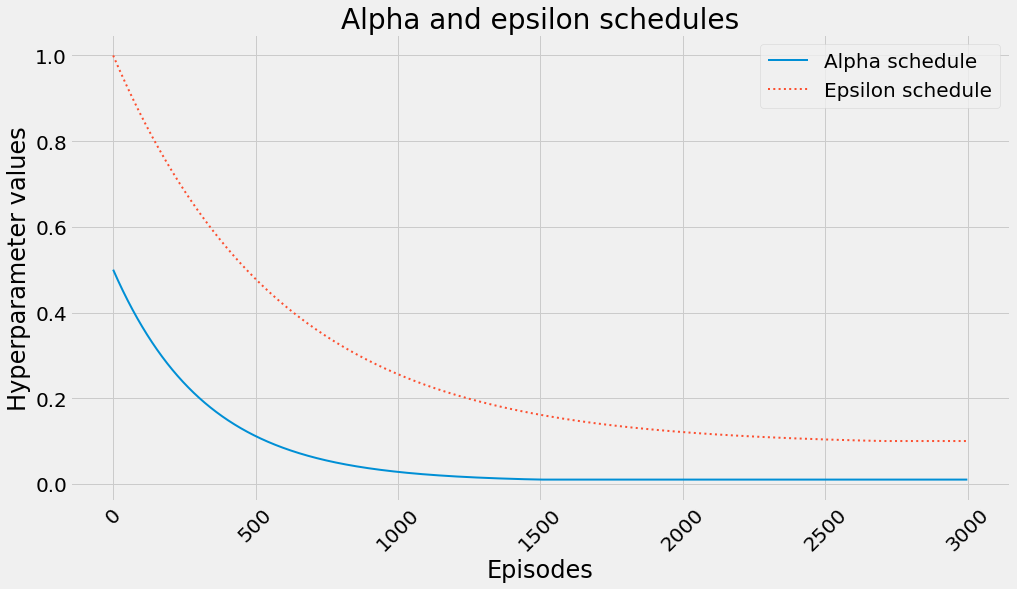

In [42]:
plt.plot(decay_schedule(0.5, 0.01, 0.5, n_episodes), 
         '-', linewidth=2, 
         label='Alpha schedule')
plt.plot(decay_schedule(1.0, 0.1, 0.9, n_episodes), 
         ':', linewidth=2, 
         label='Epsilon schedule')
plt.legend(loc=1, ncol=1)

plt.title('Alpha and epsilon schedules')
plt.xlabel('Episodes')
plt.ylabel('Hyperparameter values')
plt.xticks(rotation=45)

plt.show()

### Optimal value functions and policy

In [43]:
optimal_Q, optimal_V, optimal_pi = value_iteration(P, gamma=gamma)
print_state_value_function(optimal_V, P, n_cols=n_cols, prec=svf_prec, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Optimal action-value function:')
print()
print_policy(optimal_pi, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_op, mean_return_op, mean_regret_op = get_policy_metrics(
    env, gamma=gamma, pi=optimal_pi, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_op, mean_return_op, mean_regret_op))

Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |

Optimal action-value function:
╒═════╤═══════╤═══════╕
│   s │     < │     > │
╞═════╪═══════╪═══════╡
│   0 │ 0     │ 0     │
├─────┼───────┼───────┤
│   1 │ 0.312 │ 0.564 │
├─────┼───────┼───────┤
│   2 │ 0.67  │ 0.763 │
├─────┼───────┼───────┤
│   3 │ 0.803 │ 0.845 │
├─────┼───────┼───────┤
│   4 │ 0.864 │ 0.889 │
├─────┼───────┼───────┤
│   5 │ 0.901 │ 0.922 │
├─────┼───────┼───────┤
│   6 │ 0.932 │ 0.952 │
├─────┼───────┼───────┤
│   7 │ 0.961 │ 0.981 │
├─────┼───────┼───────┤
│   8 │ 0     │ 0     │
╘═════╧═══════╧═══════╛

Policy:
|           | 01      > | 02      > | 03      > | 04      > | 05      > | 06      > | 07      > |           |
Reaches goal 96.00%. Obtains an average return of 0.8548. Regret of 0.0000


### Sarsa(lambda_)

In [50]:
def sarsa_lambda(env,
                 gamma=1.0,
                 init_alpha=0.5,
                 min_alpha=0.01,
                 alpha_decay_ratio=0.5,
                 init_epsilon=1.0,
                 min_epsilon=0.1,
                 epsilon_decay_ratio=0.9,
                 lambda_=0.5,
                 replacing_traces=True,
                 n_episodes=3000):
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)

    Q_track = np.zeros((n_episodes, nS, nA), 
                       dtype=np.float64)
    E = np.zeros((nS, nA), dtype=np.float64)
    select_action = lambda state, Q, epsilon: \
        np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    alphas = decay_schedule(
        init_alpha, min_alpha, 
        alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(
        init_epsilon, min_epsilon, 
        epsilon_decay_ratio, n_episodes)
    
    for e in tqdm(range(n_episodes), leave=False):
        E.fill(0)

        state, done = env.reset(), False
        action = select_action(state, Q, epsilons[e])
        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action = select_action(next_state, Q, epsilons[e])

            td_target = reward + gamma * Q[next_state][next_action] * (not done)
            td_error = td_target - Q[state][action]
            if replacing_traces: E[state].fill(0)
            E[state][action] = E[state][action] + 1
            if replacing_traces: E.clip(0, 1, out=E)
            Q = Q + alphas[e] * td_error * E
            E = gamma * lambda_ * E
            
            state, action = next_state, next_action

        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [51]:
Q_rsls, V_rsls, Q_track_rsls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_rsl, V_rsl, pi_rsl, Q_track_rsl, pi_track_rsl = sarsa_lambda(env, gamma=gamma, n_episodes=n_episodes)
    Q_rsls.append(Q_rsl) ; V_rsls.append(V_rsl) ; Q_track_rsls.append(Q_track_rsl)
Q_rsl, V_rsl, Q_track_rsl = np.mean(Q_rsls, axis=0), np.mean(V_rsls, axis=0), np.mean(Q_track_rsls, axis=0)
del Q_rsls ; del V_rsls ; del Q_track_rsls

In [52]:
print_state_value_function(V_rsl, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Sarsa(λ) replacing:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_rsl - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_rsl, optimal_V)))
print()
print_action_value_function(Q_rsl, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Sarsa(λ) replacing action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_rsl, optimal_Q)))
print()
print_policy(pi_rsl, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_rsl, mean_return_rsl, mean_regret_rsl = get_policy_metrics(
    env, gamma=gamma, pi=pi_rsl, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_rsl, mean_return_rsl, mean_regret_rsl))

State-value function found by Sarsa(λ) replacing:
|           | 01 0.4672 | 02 0.6985 | 03 0.8056 | 04 0.8656 | 05 0.9102 | 06 0.9436 | 07 0.9773 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01   -0.1 | 02  -0.06 | 03  -0.04 | 04  -0.02 | 05  -0.01 | 06  -0.01 | 07   -0.0 |           |
State-value function RMSE: 0.0419

Sarsa(λ) replacing action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╕
│   s │     < │     > │   * < │   * > │   err < │   err > │
╞═════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╡
│   0 │ 0     │ 0     │ 0     │ 0     │   0     │   0     │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   1 │ 0.195 │ 0.467 │ 0.312 │ 0.564 │   0.117 │   0.097 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   2 │ 0.512 │ 0.698 │ 0.67  │ 0.763 │   0.158 │   0.065 │
├───

In [53]:
Q_asls, V_asls, Q_track_asls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_asl, V_asl, pi_asl, Q_track_asl, pi_track_asl = sarsa_lambda(env, gamma=gamma, 
                                                                   replacing_traces=False, 
                                                                   n_episodes=n_episodes)
    Q_asls.append(Q_asl) ; V_asls.append(V_asl) ; Q_track_asls.append(Q_track_asl)
Q_asl, V_asl, Q_track_asl = np.mean(Q_asls, axis=0), np.mean(V_asls, axis=0), np.mean(Q_track_asls, axis=0)
del Q_asls ; del V_asls ; del Q_track_asls

In [54]:
print_state_value_function(V_asl, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Sarsa(λ) accumulating:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_asl - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_asl, optimal_V)))
print()
print_action_value_function(Q_asl, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Sarsa(λ) accumulating action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_asl, optimal_Q)))
print()
print_policy(pi_asl, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_asl, mean_return_asl, mean_regret_asl = get_policy_metrics(
    env, gamma=gamma, pi=pi_asl, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_asl, mean_return_asl, mean_regret_asl))

State-value function found by Sarsa(λ) accumulating:
|           | 01 0.4814 | 02 0.7085 | 03 0.8168 | 04 0.8683 | 05 0.9082 | 06 0.9443 | 07 0.9783 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01  -0.08 | 02  -0.05 | 03  -0.03 | 04  -0.02 | 05  -0.01 | 06  -0.01 | 07   -0.0 |           |
State-value function RMSE: 0.0353

Sarsa(λ) accumulating action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╕
│   s │     < │     > │   * < │   * > │   err < │   err > │
╞═════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╡
│   0 │ 0     │ 0     │ 0     │ 0     │   0     │   0     │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   1 │ 0.207 │ 0.481 │ 0.312 │ 0.564 │   0.105 │   0.082 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   2 │ 0.539 │ 0.709 │ 0.67  │ 0.763 │   0.131 │   0.055 

In [55]:
Q_asls, V_asls, Q_track_asls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_asl, V_asl, pi_asl, Q_track_asl, pi_track_asl = sarsa_lambda(env, gamma=gamma, 
                                                                   replacing_traces=False, 
                                                                   n_episodes=n_episodes)
    Q_asls.append(Q_asl) ; V_asls.append(V_asl) ; Q_track_asls.append(Q_track_asl)
Q_asl, V_asl, Q_track_asl = np.mean(Q_asls, axis=0), np.mean(V_asls, axis=0), np.mean(Q_track_asls, axis=0)
del Q_asls ; del V_asls ; del Q_track_asls

In [56]:
print_state_value_function(V_asl, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Sarsa(λ) accumulating:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_asl - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_asl, optimal_V)))
print()
print_action_value_function(Q_asl, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Sarsa(λ) accumulating action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_asl, optimal_Q)))
print()
print_policy(pi_asl, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_asl, mean_return_asl, mean_regret_asl = get_policy_metrics(
    env, gamma=gamma, pi=pi_asl, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_asl, mean_return_asl, mean_regret_asl))

State-value function found by Sarsa(λ) accumulating:
|           | 01 0.4814 | 02 0.7085 | 03 0.8168 | 04 0.8683 | 05 0.9082 | 06 0.9443 | 07 0.9783 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01  -0.08 | 02  -0.05 | 03  -0.03 | 04  -0.02 | 05  -0.01 | 06  -0.01 | 07   -0.0 |           |
State-value function RMSE: 0.0353

Sarsa(λ) accumulating action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╕
│   s │     < │     > │   * < │   * > │   err < │   err > │
╞═════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╡
│   0 │ 0     │ 0     │ 0     │ 0     │   0     │   0     │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   1 │ 0.207 │ 0.481 │ 0.312 │ 0.564 │   0.105 │   0.082 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   2 │ 0.539 │ 0.709 │ 0.67  │ 0.763 │   0.131 │   0.055 

### Watkins Q(lambda_)

In [57]:
def q_lambda(env, 
             gamma = 1.0, 
             init_alpha = 0.5, 
             min_alpha = 0.01, 
             alpha_decay_ratio = 0.5, 
             init_epsilon = 1.0, 
             min_epsilon = 0.1, 
             epsilon_decay_ration = 0.9, 
             lambda_ = 0.5,
             replacing_traces = True, 
             n_episodes = 3000):
    nS, nA = env.observation_space.n, env.action_space.n 

    Q = np.zeros((nS, nA), dtype = np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype = np.float64)

    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ration, n_episodes)

    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) if np.random.random()> epsilon \
                        else np.random.randint(len(Q[state]))
    
    E = np.zeros((nS, nA), dtype = np.float64)
    pi_track = []

    for e in tqdm(range(n_episodes), leave= False):
        E.fill(0)
        state, done = env.reset(), False 
        action = select_action(state, Q, epsilons[e])

        while not done: 
            
            next_state, reward, done, _ = env.step(action)
            next_action = select_action(next_state, Q, epsilons[e])

            next_action_is_greedy = Q[next_state][next_action] == Q[state][action]
            td_target = reward + gamma*Q[next_state].max()*(not done)
            td_error   = td_target - Q[state][action]

            if replacing_traces: E[state].fill(0)
            E[state][action] += 1 

            if replacing_traces: E.clip(0, 1, out = E)
            Q += alphas[e]*td_error*E

            if next_action_is_greedy: 
                E = gamma*lambda_*E 

            else: 
                E.fill(0)

            state, action = next_state, next_action 

        Q_track[e] = Q 
        pi_track.append(np.argmax(Q, axis = 1))

    V = np.max(Q, axis = 1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis = 1))}[s]

    return Q, V, pi, Q_track, pi_track

In [58]:
Q_rqlls, V_rqlls, Q_track_rqlls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_rqll, V_rqll, pi_rqll, Q_track_rqll, pi_track_rqll = q_lambda(env, gamma=gamma, n_episodes=n_episodes)
    Q_rqlls.append(Q_rqll) ; V_rqlls.append(V_rqll) ; Q_track_rqlls.append(Q_track_rqll)
Q_rqll, V_rqll, Q_track_rqll = np.mean(Q_rqlls, axis=0), np.mean(V_rqlls, axis=0), np.mean(Q_track_rqlls, axis=0)
del Q_rqlls ; del V_rqlls ; del Q_track_rqlls

In [59]:
print_state_value_function(V_rqll, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Q(λ) replacing:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_rqll - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_rqll, optimal_V)))
print()
print_action_value_function(Q_rqll, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Q(λ) replacing action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_rqll, optimal_Q)))
print()
print_policy(pi_rqll, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_rqll, mean_return_rqll, mean_regret_rqll = get_policy_metrics(
    env, gamma=gamma, pi=pi_rqll, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_rqll, mean_return_rqll, mean_regret_rqll))

State-value function found by Q(λ) replacing:
|           | 01 0.5564 | 02 0.7554 | 03 0.8401 | 04 0.8892 | 05 0.9217 | 06  0.952 | 07 0.9814 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01  -0.01 | 02  -0.01 | 03   -0.0 | 04   -0.0 | 05   -0.0 | 06    0.0 | 07    0.0 |           |
State-value function RMSE: 0.0039

Q(λ) replacing action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╕
│   s │     < │     > │   * < │   * > │   err < │   err > │
╞═════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╡
│   0 │ 0     │ 0     │ 0     │ 0     │   0     │   0     │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   1 │ 0.301 │ 0.556 │ 0.312 │ 0.564 │   0.011 │   0.007 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   2 │ 0.656 │ 0.755 │ 0.67  │ 0.763 │   0.014 │   0.008 │
├─────┼─────

In [60]:
Q_aqlls, V_aqlls, Q_track_aqlls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_aqll, V_aqll, pi_aqll, Q_track_aqll, pi_track_aqll = q_lambda(env, gamma=gamma, 
                                                                    replacing_traces=False,
                                                                    n_episodes=n_episodes)
    Q_aqlls.append(Q_aqll) ; V_aqlls.append(V_aqll) ; Q_track_aqlls.append(Q_track_aqll)
Q_aqll, V_aqll, Q_track_aqll = np.mean(Q_aqlls, axis=0), np.mean(V_aqlls, axis=0), np.mean(Q_track_aqlls, axis=0)
del Q_aqlls ; del V_aqlls ; del Q_track_aqlls

In [61]:
print_state_value_function(V_aqll, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Q(λ) accumulating:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_aqll - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_aqll, optimal_V)))
print()
print_action_value_function(Q_aqll, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Q(λ) accumulating action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_aqll, optimal_Q)))
print()
print_policy(pi_aqll, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_aqll, mean_return_aqll, mean_regret_aqll = get_policy_metrics(
    env, gamma=gamma, pi=pi_aqll, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_aqll, mean_return_aqll, mean_regret_aqll))

State-value function found by Q(λ) accumulating:
|           | 01 0.5605 | 02 0.7599 | 03 0.8415 | 04 0.8884 | 05 0.9218 | 06 0.9528 | 07 0.9813 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01   -0.0 | 02   -0.0 | 03   -0.0 | 04   -0.0 | 05   -0.0 | 06    0.0 | 07    0.0 |           |
State-value function RMSE: 0.0019

Q(λ) accumulating action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╕
│   s │     < │     > │   * < │   * > │   err < │   err > │
╞═════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╡
│   0 │ 0     │ 0     │ 0     │ 0     │   0     │   0     │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   1 │ 0.31  │ 0.561 │ 0.312 │ 0.564 │   0.002 │   0.003 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   2 │ 0.68  │ 0.76  │ 0.67  │ 0.763 │  -0.009 │   0.003 │
├─────

# Dyna-Q 

In [68]:
def dyna_q(env, gamma = 1.0, init_alpha = 0.5, 
           min_alpha = 0.01, 
           alpha_decay_ratio = 0.5, 
           init_epsilon = 1.0, 
           min_epsilon = 0.1, 
           epsilon_decay_ratio = 0.9, 
           n_planning = 3, 
           n_episodes = 3000):
    nS, nA = env.observation_space.n, env.action_space.n 
    pi_track, T_track, R_track, planning_track = [], [], [], []
    Q = np.zeros((nS, nA), dtype = np.float64)
    T_count = np.zeros((nS, nA, nS), dtype = np.int)
    R_model = np.zeros((nS, nA, nS), dtype = np.float64)


    Q_track = np.zeros((n_episodes, nS, nA), dtype = np.float64)

    select_action = lambda state, Q, epsilon: \
        np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)


    for e in tqdm(range(n_episodes), leave= False):
        state, done = env.reset(), False
        
        while not done: 
            action = select_action(state, Q, epsilons[e])
            next_state, reward, done, _ = env.step(action)

            T_count[state][action][next_state] += 1 
            r_diff = reward - R_model[state][action][next_state]
            R_model[state][action][next_state] += (r_diff/T_count[state][action][next_state])

            td_target = reward + gamma* Q[next_state].max()*(not done)
            td_error = td_target - Q[state][action]
            Q[state][action] += alphas[e]*td_error

            backup_next_state = next_state 

            for _ in range(n_planning):
                if Q.sum() == 0: break 

                visited_states = np.where(np.sum(T_count, axis = (1,2))>0)[0]
                action = np.random.choice(visited_states)

                actions_taken = np.where(np.sum(T_count[state], axis = 1) > 0)[0]
                action = np.random.choice(actions_taken)

                probs = T_count[state][action]/T_count[state][action].sum()
                next_state = np.random.choice(np.arange(nS), size = 1,  p = probs)[0]
                reward = R_model[state][action][next_state]
                planning_track.append((state, action, reward, next_state))

                td_target = reward + gamma*Q[next_state].max()
                td_error = td_target - Q[state][action]
                Q[state][action] += alphas[e]*td_error 

            state = backup_next_state

        T_track.append(T_count.copy())
        R_track.append(R_model.copy())
        Q_track[e] = Q 
        pi_track.append(np.argmax(Q, axis = 1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track, T_track, R_track, np.array(planning_track)

In [69]:
Q_dqs, V_dqs, Q_track_dqs = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_dq, V_dq, pi_dq, Q_track_dq, pi_track_dq, T_track_dq, R_track_dq, planning_dq = dyna_q(
        env, gamma=gamma, n_episodes=n_episodes)
    Q_dqs.append(Q_dq) ; V_dqs.append(V_dq) ; Q_track_dqs.append(Q_track_dq)
Q_dq, V_dq, Q_track_dq = np.mean(Q_dqs, axis=0), np.mean(V_dqs, axis=0), np.mean(Q_track_dqs, axis=0)
del Q_dqs ; del V_dqs ; del Q_track_dqs

In [70]:
print_state_value_function(V_dq, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Dyna-Q:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_dq - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_dq, optimal_V)))
print()
print_action_value_function(Q_dq, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Dyna-Q action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_dq, optimal_Q)))
print()
print_policy(pi_dq, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_dq, mean_return_dq, mean_regret_dq = get_policy_metrics(
    env, gamma=gamma, pi=pi_dq, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_dq, mean_return_dq, mean_regret_dq))

State-value function found by Dyna-Q:
|           | 01 0.5613 | 02 0.7594 | 03 0.8414 | 04 0.8885 | 05 0.9212 | 06  0.951 | 07 0.9812 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01   -0.0 | 02   -0.0 | 03   -0.0 | 04   -0.0 | 05   -0.0 | 06   -0.0 | 07    0.0 |           |
State-value function RMSE: 0.0019

Dyna-Q action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╕
│   s │     < │     > │   * < │   * > │   err < │   err > │
╞═════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╡
│   0 │ 0     │ 0     │ 0     │ 0     │   0     │   0     │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   1 │ 0.301 │ 0.561 │ 0.312 │ 0.564 │   0.011 │   0.002 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   2 │ 0.668 │ 0.759 │ 0.67  │ 0.763 │   0.003 │   0.004 │
├─────┼───────┼───────┼─────

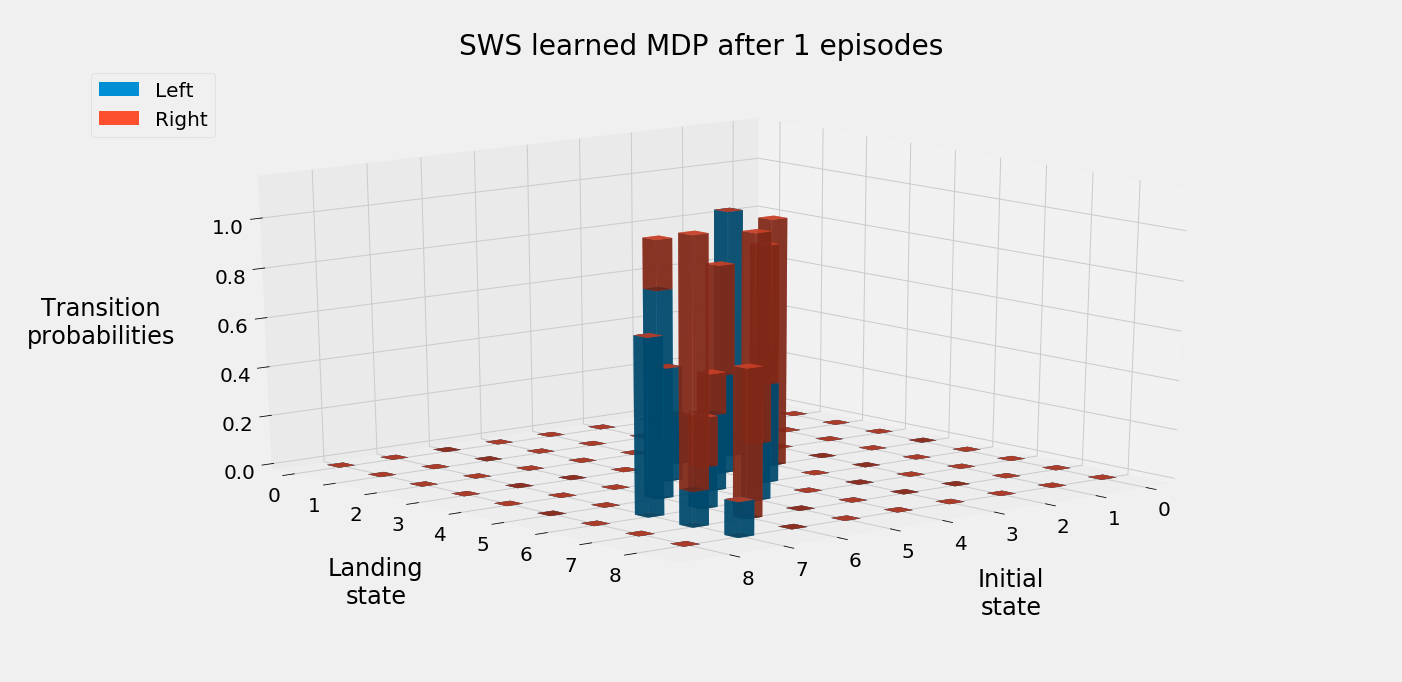

In [71]:
plot_transition_model(T_track_dq, episode=0)

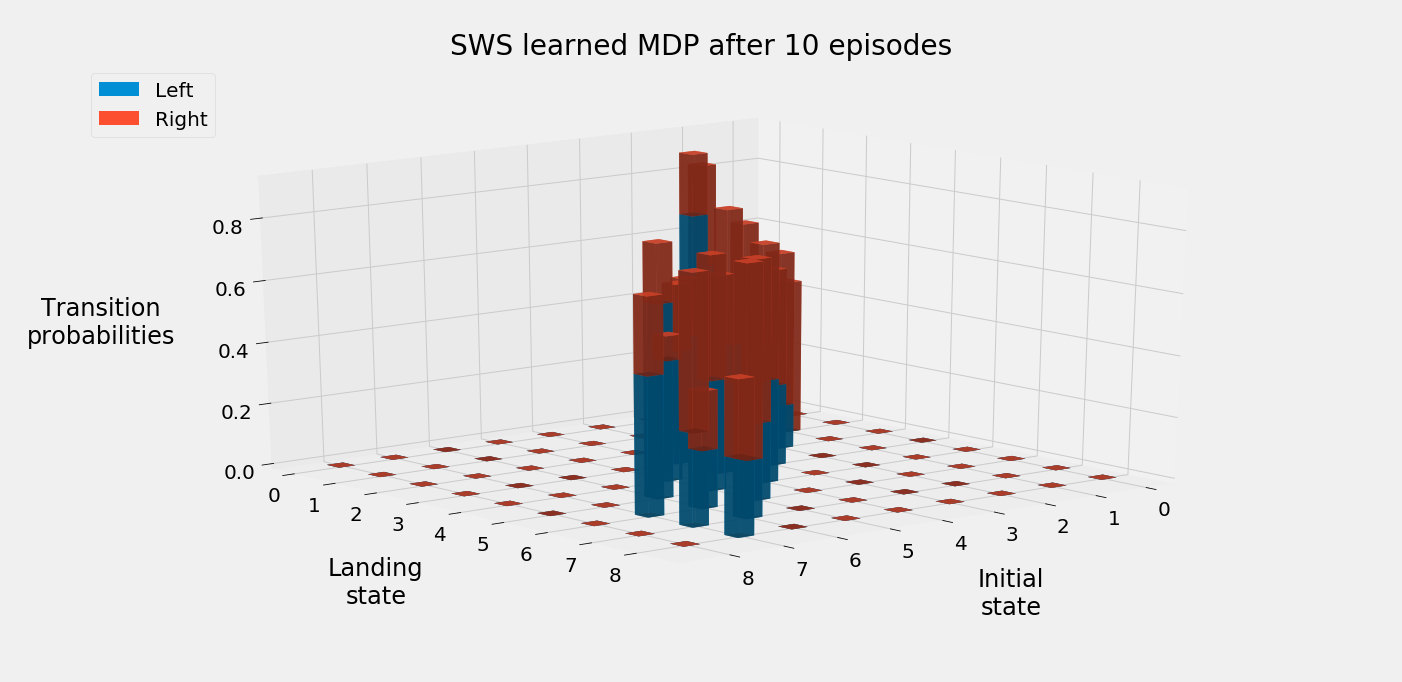

In [72]:
plot_transition_model(T_track_dq, episode=9)

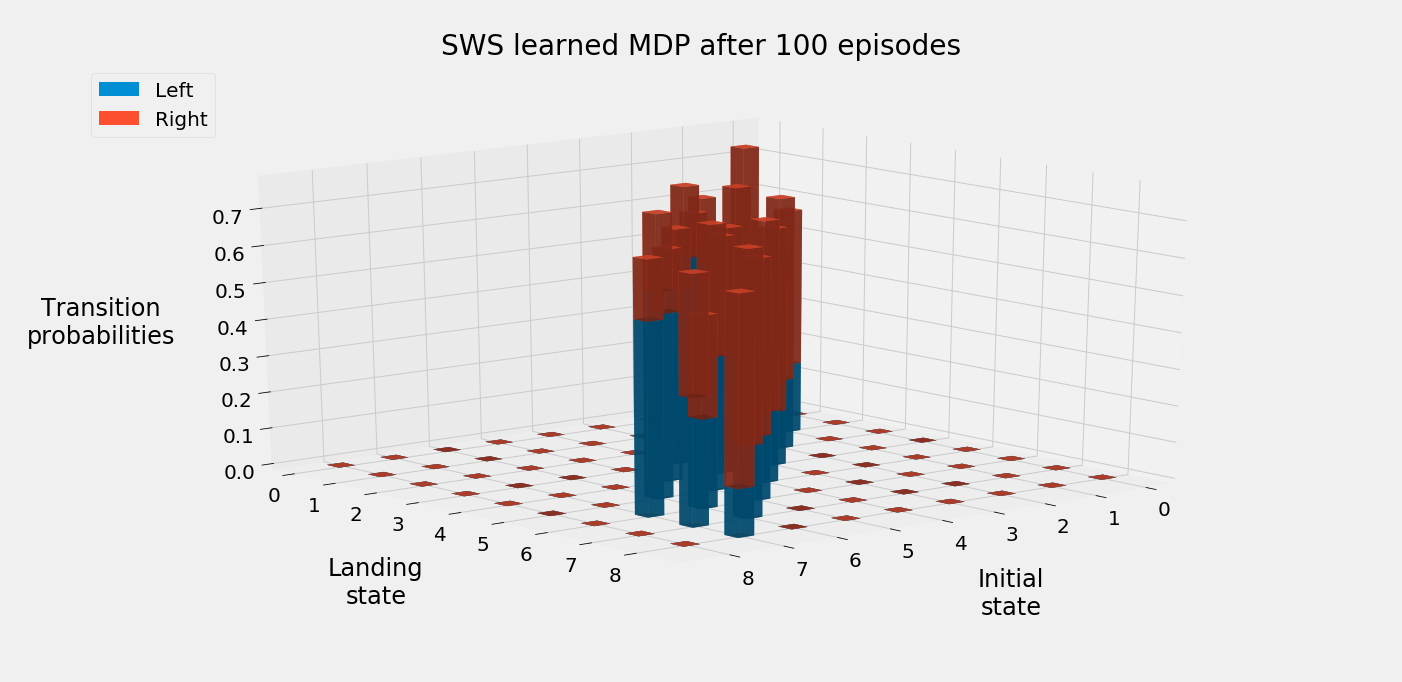

In [73]:
plot_transition_model(T_track_dq, episode=99)

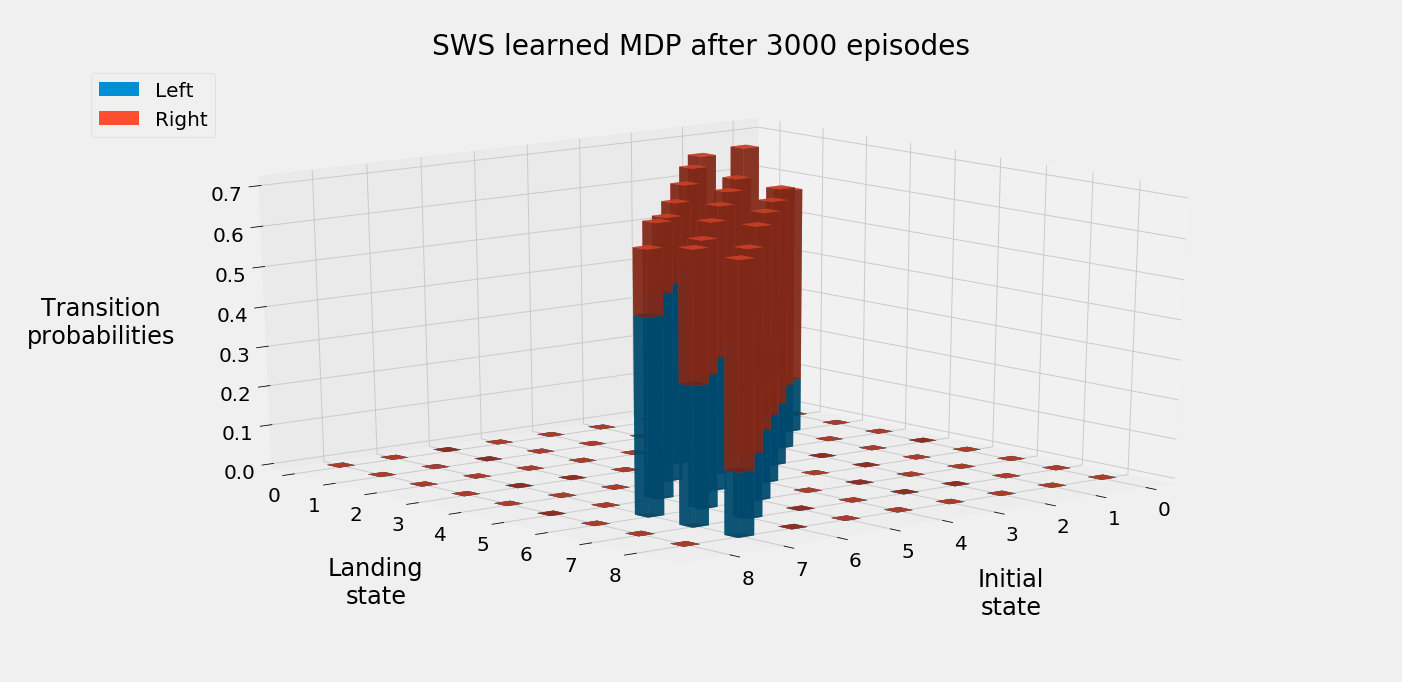

In [74]:
plot_transition_model(T_track_dq, episode=len(T_track_dq)-1)

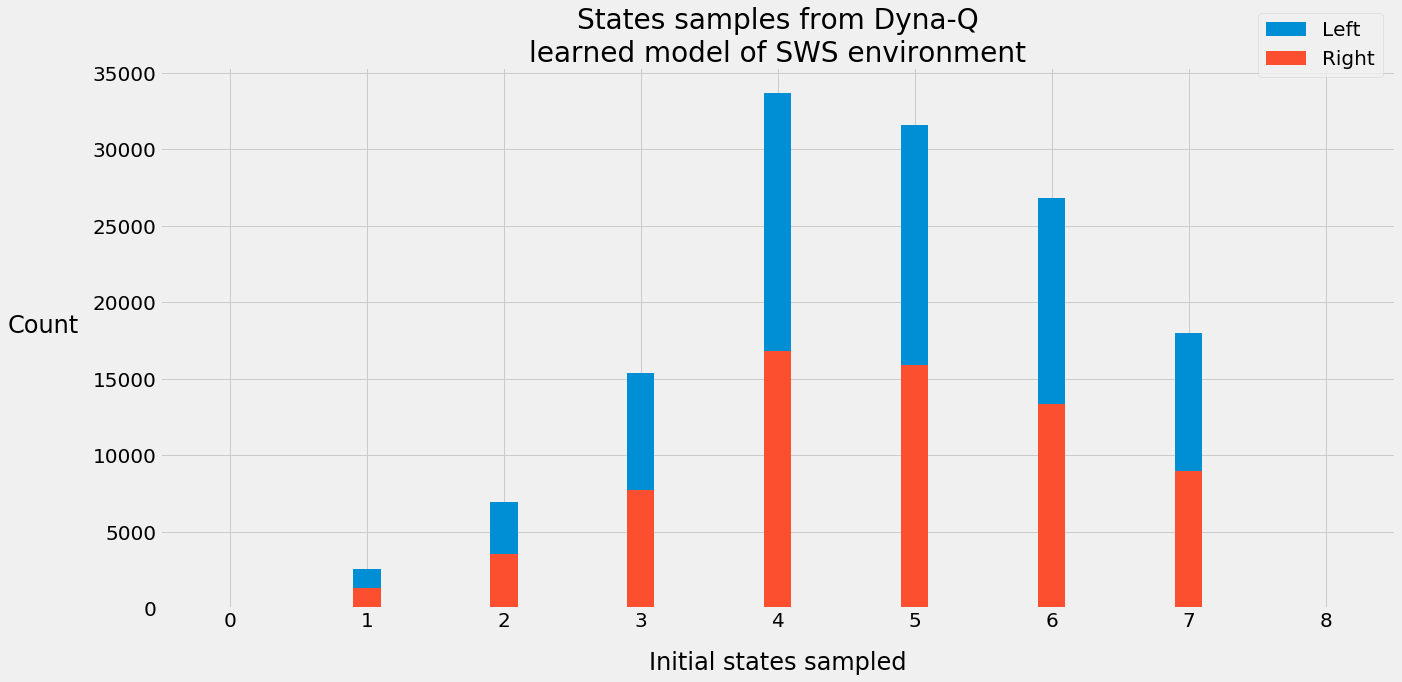

In [75]:
plot_model_state_sampling(planning_dq, algo='Dyna-Q')

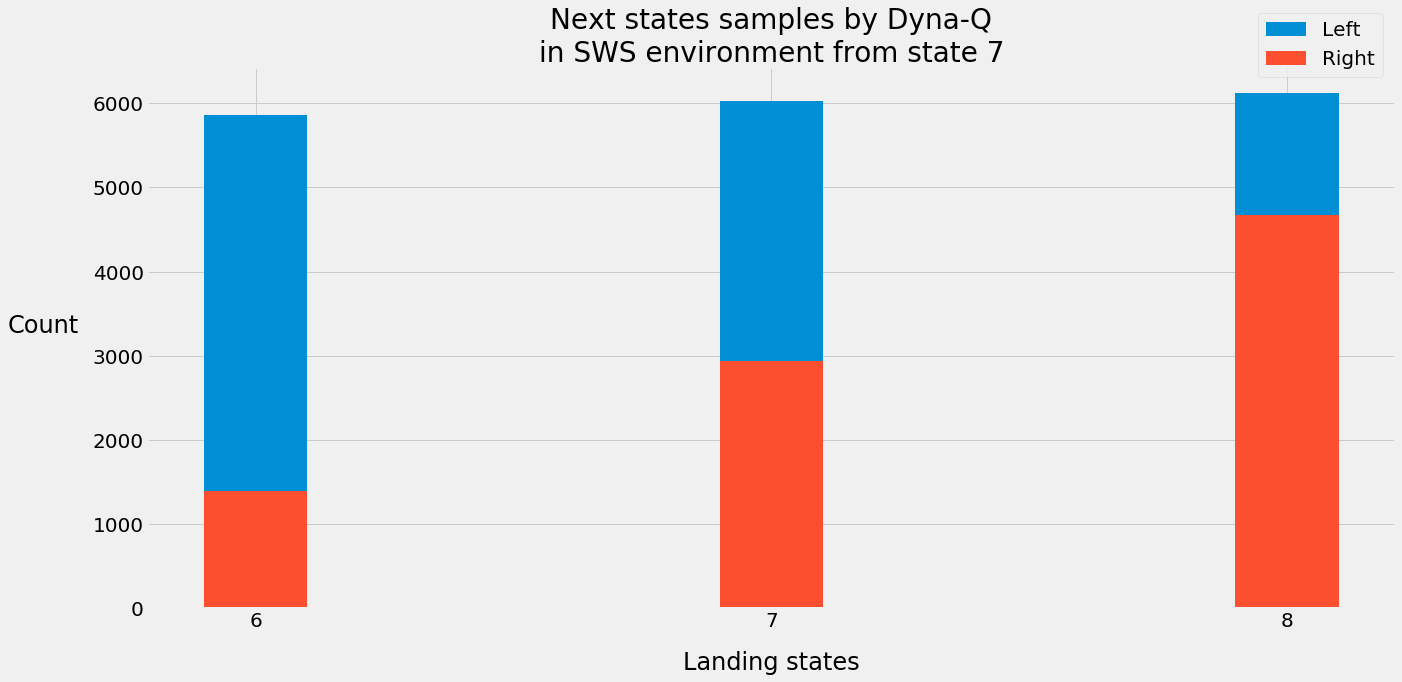

In [76]:
plot_model_state_7(planning_dq, algo='Dyna-Q')

# Trajectory Sampling

In [77]:
def trajectory_sampling(env,
                        gamma=1.0,
                        init_alpha=0.5,
                        min_alpha=0.01,
                        alpha_decay_ratio=0.5,
                        init_epsilon=1.0,
                        min_epsilon=0.1,
                        epsilon_decay_ratio=0.9,
                        max_trajectory_depth=100,
                        planning_freq=5,
                        greedy_planning=True,
                        n_episodes=3000):
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track, T_track, R_track, planning_track = [], [], [], []
    Q = np.zeros((nS, nA), dtype=np.float64)
    T_count = np.zeros((nS, nA, nS), dtype=np.int)
    R_model = np.zeros((nS, nA, nS), dtype=np.float64)

    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    select_action = lambda state, Q, epsilon: \
        np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    alphas = decay_schedule(
        init_alpha, min_alpha, 
        alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(
        init_epsilon, min_epsilon, 
        epsilon_decay_ratio, n_episodes)

    for e in tqdm(range(n_episodes), leave=False):
        state, done = env.reset(), False

        while not done:
            action = select_action(state, Q, epsilons[e])
            next_state, reward, done, _ = env.step(action)
            
            T_count[state][action][next_state] += 1
            r_diff = reward - R_model[state][action][next_state]
            R_model[state][action][next_state] += (r_diff / T_count[state][action][next_state])

            td_target = reward + gamma * Q[next_state].max() * (not done)
            td_error = td_target - Q[state][action]
            Q[state][action] = Q[state][action] + alphas[e] * td_error
            
            backup_next_state = next_state

            if e % planning_freq == 0:
                for _ in range(max_trajectory_depth):
                    if Q.sum() == 0: break

                    action = Q[state].argmax() if greedy_planning else \
                        select_action(state, Q, epsilons[e])
                    if not T_count[state][action].sum(): break
                    probs = T_count[state][action]/T_count[state][action].sum()
                    next_state = np.random.choice(np.arange(nS), size=1, p=probs)[0]
                    reward = R_model[state][action][next_state]
                    planning_track.append((state, action, reward, next_state))

                    td_target = reward + gamma * Q[next_state].max()
                    td_error = td_target - Q[state][action]
                    Q[state][action] = Q[state][action] + alphas[e] * td_error

                    state = next_state

            state = backup_next_state

        T_track.append(T_count.copy())
        R_track.append(R_model.copy())

        Q_track[e] = Q        
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track, T_track, R_track, np.array(planning_track)

In [78]:
Q_tss, V_tss, Q_track_tss = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_ts, V_ts, pi_ts, Q_track_ts, pi_track_ts, T_track_ts, R_track_ts, planning_ts = trajectory_sampling(
        env, gamma=gamma, n_episodes=n_episodes)
    Q_tss.append(Q_ts) ; V_tss.append(V_ts) ; Q_track_tss.append(Q_track_ts)
Q_ts, V_ts, Q_track_ts = np.mean(Q_tss, axis=0), np.mean(V_tss, axis=0), np.mean(Q_track_tss, axis=0)
del Q_tss ; del V_tss ; del Q_track_tss

In [79]:
print_state_value_function(V_ts, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Trajectory Sampling:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_ts - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_ts, optimal_V)))
print()
print_action_value_function(Q_ts, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Trajectory Sampling action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_ts, optimal_Q)))
print()
print_policy(pi_ts, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_ts, mean_return_ts, mean_regret_ts = get_policy_metrics(
    env, gamma=gamma, pi=pi_ts, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_ts, mean_return_ts, mean_regret_ts))

State-value function found by Trajectory Sampling:
|           | 01  0.562 | 02 0.7616 | 03 0.8434 | 04 0.8869 | 05 0.9219 | 06 0.9515 | 07  0.981 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01   -0.0 | 02   -0.0 | 03   -0.0 | 04   -0.0 | 05   -0.0 | 06   -0.0 | 07    0.0 |           |
State-value function RMSE: 0.0012

Trajectory Sampling action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╕
│   s │     < │     > │   * < │   * > │   err < │   err > │
╞═════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╡
│   0 │ 0     │ 0     │ 0     │ 0     │   0     │   0     │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   1 │ 0.302 │ 0.562 │ 0.312 │ 0.564 │   0.01  │   0.002 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   2 │ 0.665 │ 0.762 │ 0.67  │ 0.763 │   0.005 │   0.001 │
├─

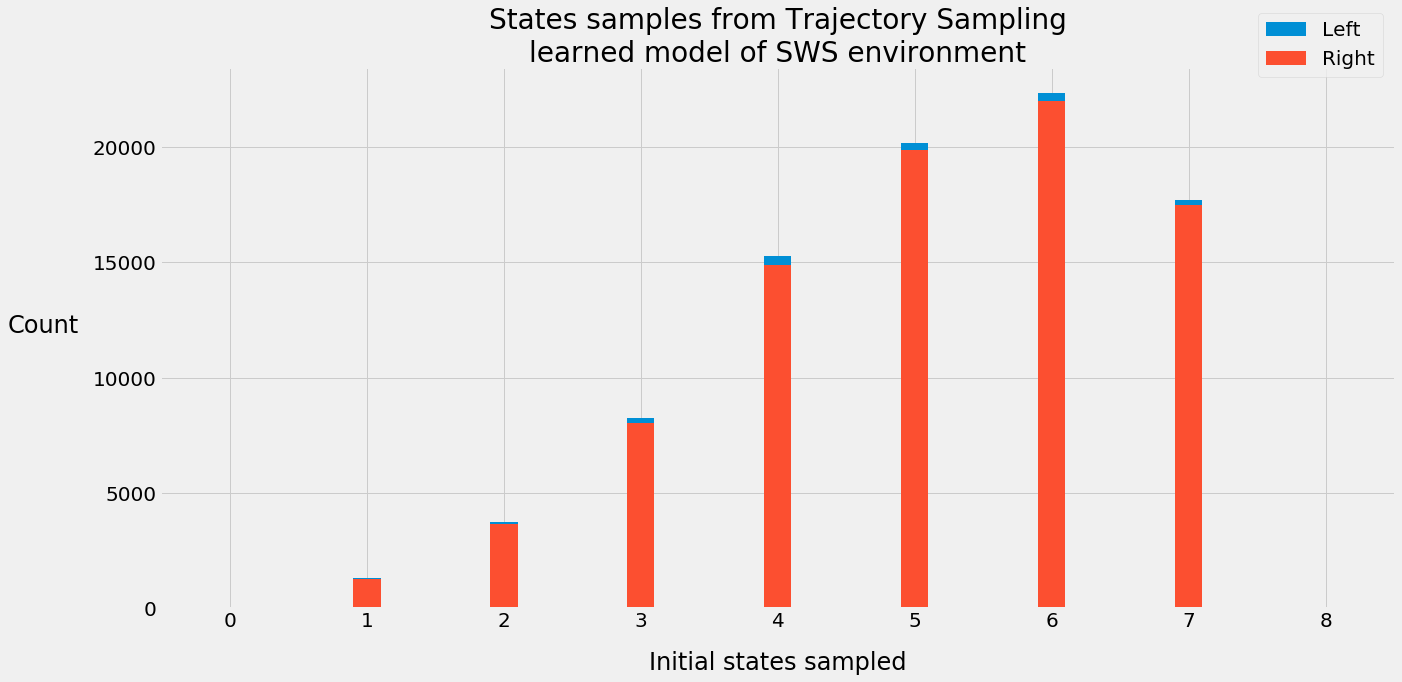

In [80]:
plot_model_state_sampling(planning_ts, algo='Trajectory Sampling')

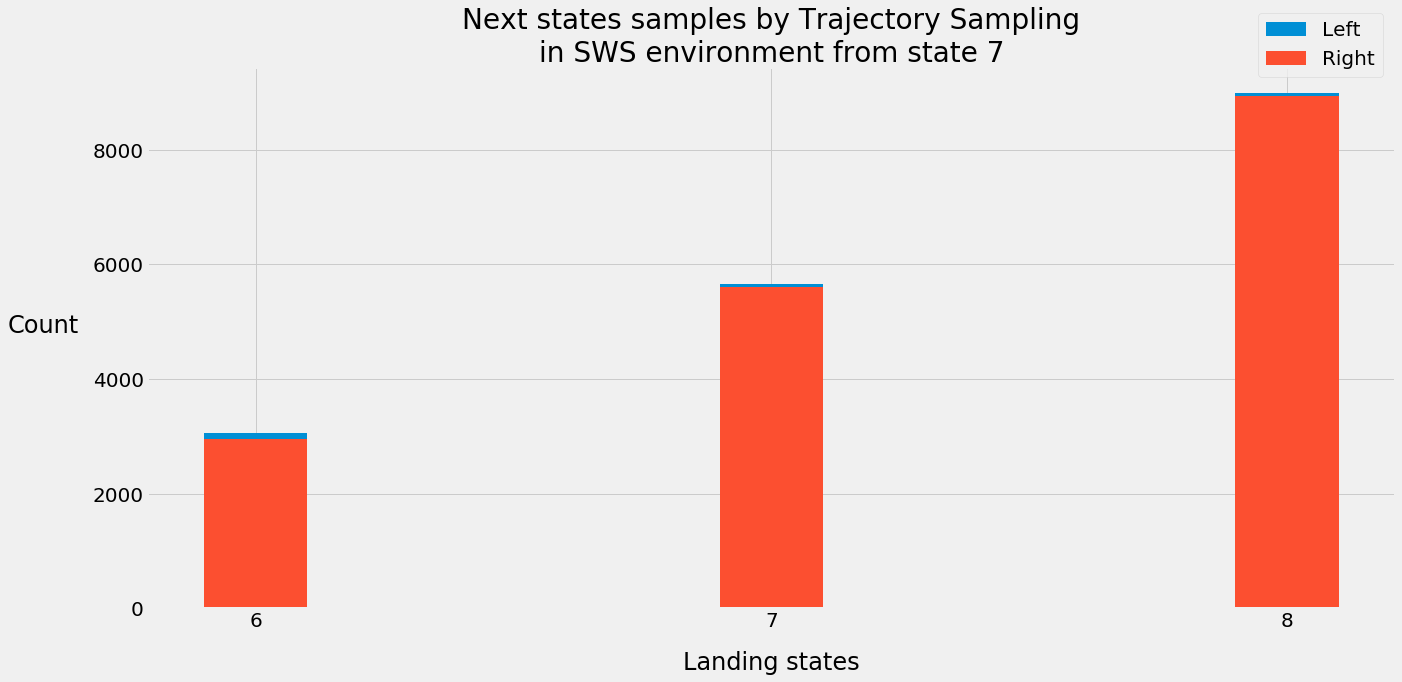

In [81]:
plot_model_state_7(planning_ts, algo='Trajectory Sampling')

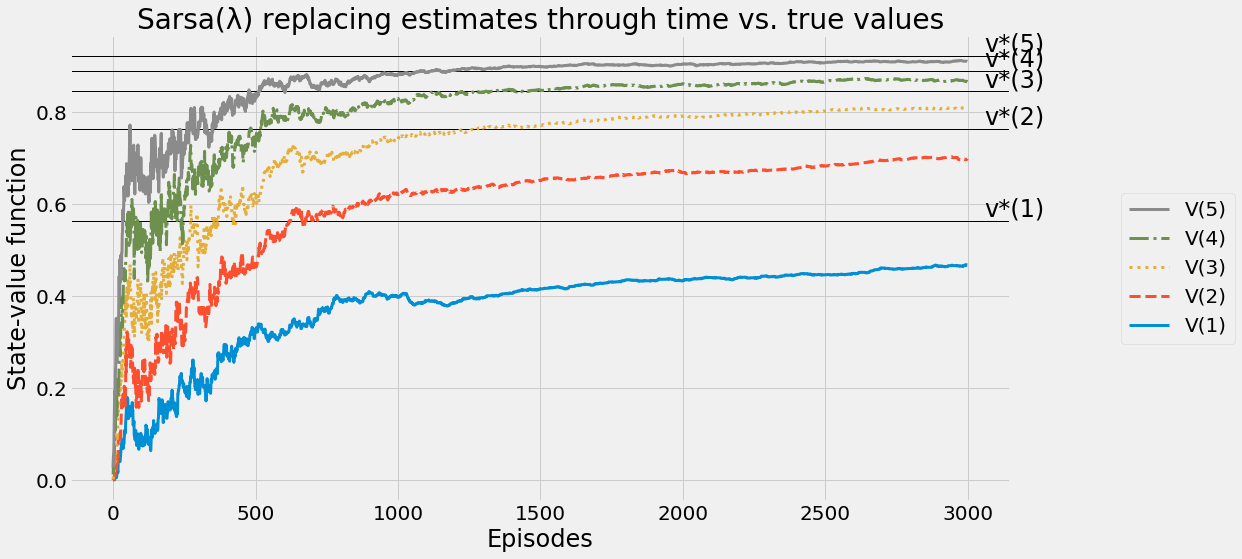

In [82]:
plot_value_function(
    'Sarsa(λ) replacing estimates through time vs. true values', 
    np.max(Q_track_rsl, axis=2), 
    optimal_V,
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)

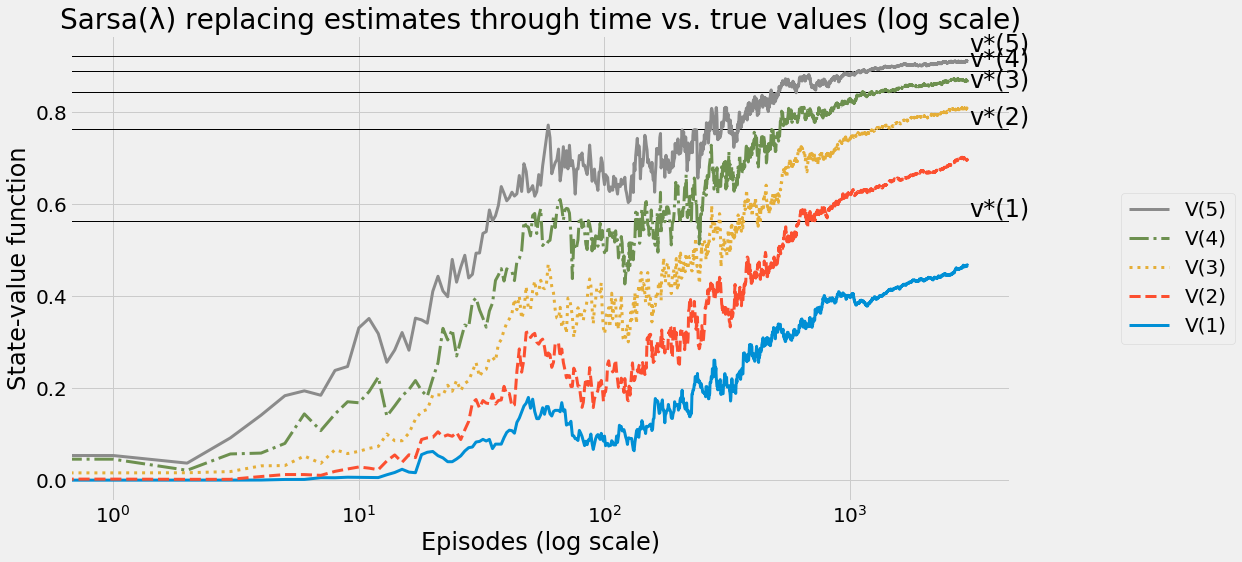

In [83]:
plot_value_function(
    'Sarsa(λ) replacing estimates through time vs. true values (log scale)', 
    np.max(Q_track_rsl, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=True)

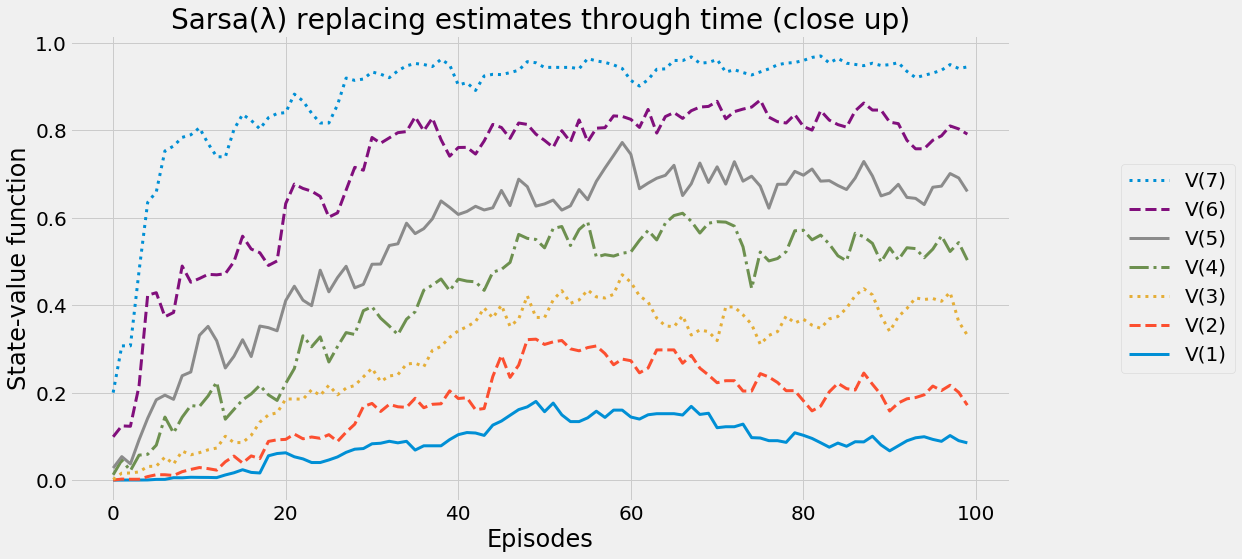

In [84]:
plot_value_function(
    'Sarsa(λ) replacing estimates through time (close up)', 
    np.max(Q_track_rsl, axis=2)[:cu_episodes], 
    None,
    limit_items=cu_limit_items,
    limit_value=cu_limit_value,
    log=False)

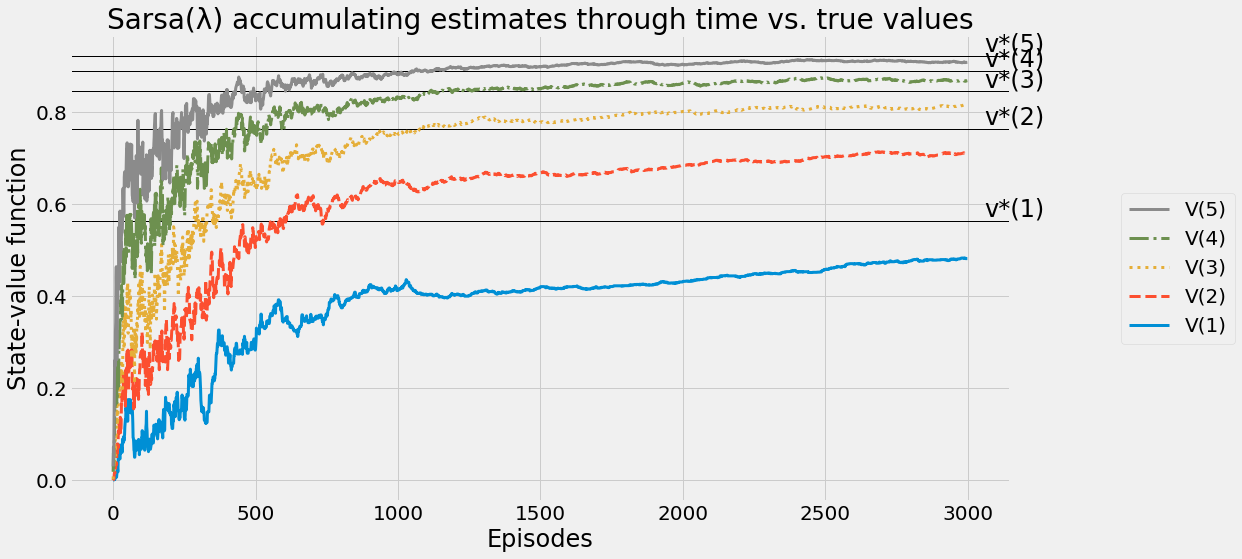

In [85]:
plot_value_function(
    'Sarsa(λ) accumulating estimates through time vs. true values', 
    np.max(Q_track_asl, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)

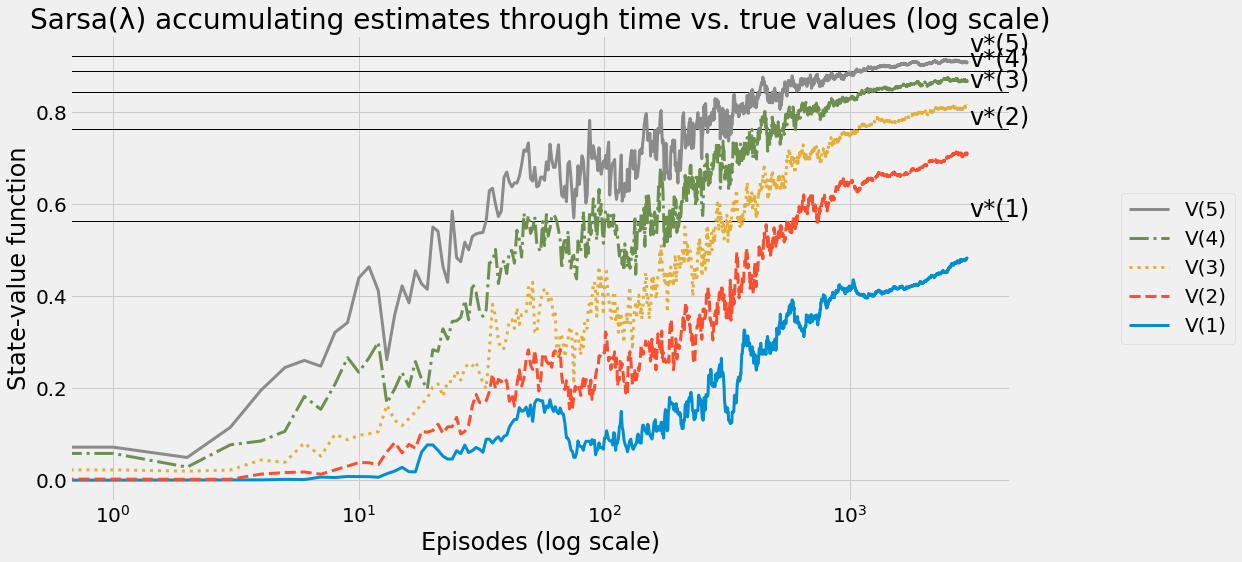

In [86]:
plot_value_function(
    'Sarsa(λ) accumulating estimates through time vs. true values (log scale)', 
    np.max(Q_track_asl, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=True)

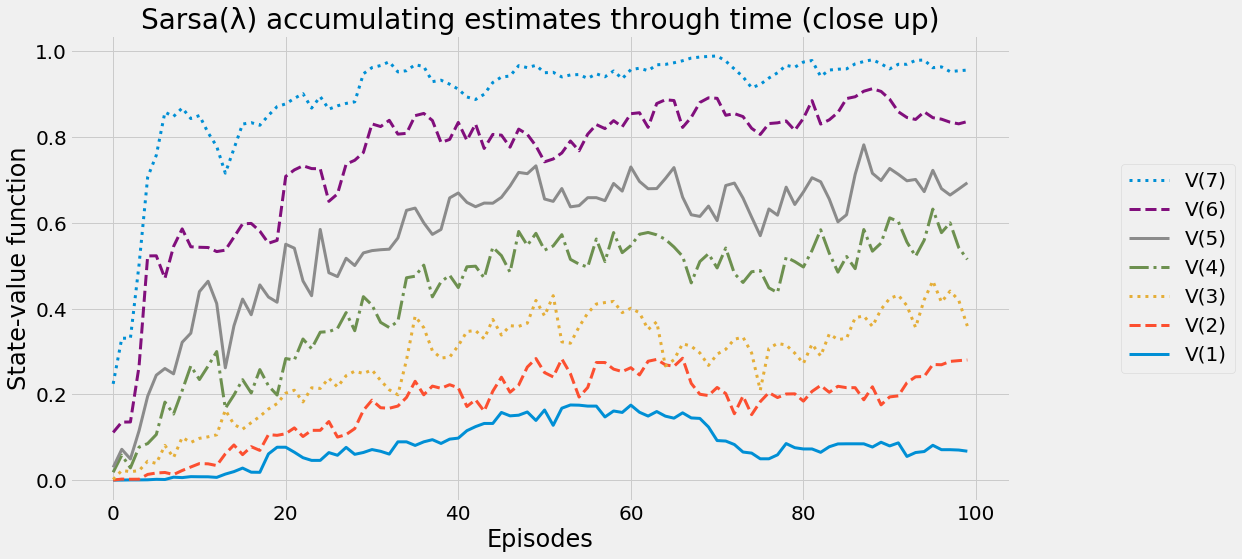

In [87]:
plot_value_function(
    'Sarsa(λ) accumulating estimates through time (close up)', 
    np.max(Q_track_asl, axis=2)[:cu_episodes], 
    None,
    limit_items=cu_limit_items,
    limit_value=cu_limit_value,
    log=False)

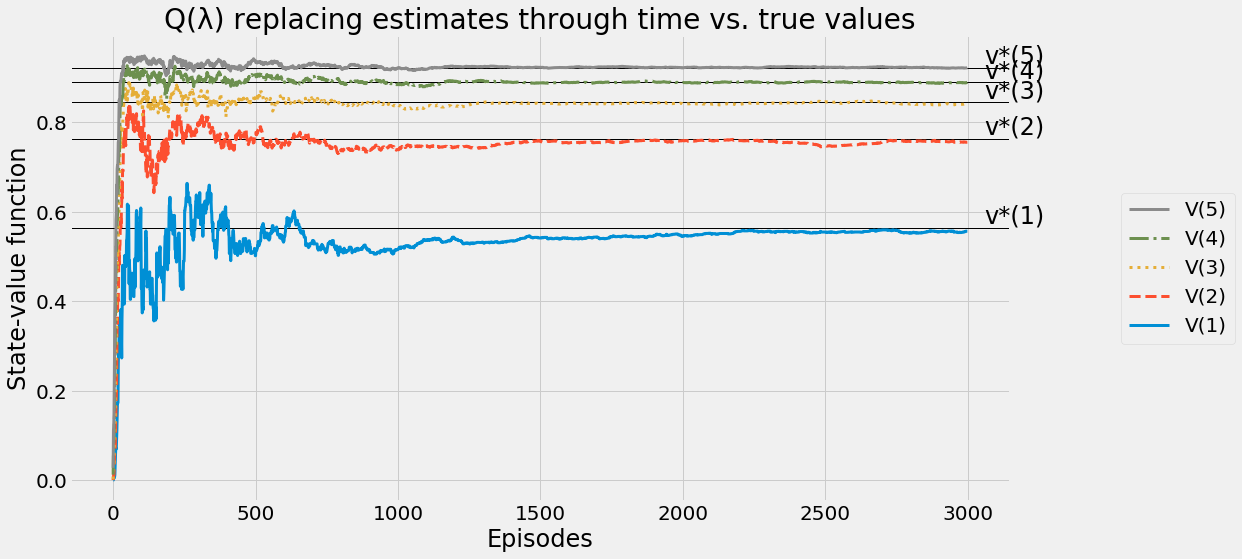

In [88]:
plot_value_function(
    'Q(λ) replacing estimates through time vs. true values', 
    np.max(Q_track_rqll, axis=2), 
    optimal_V,
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)

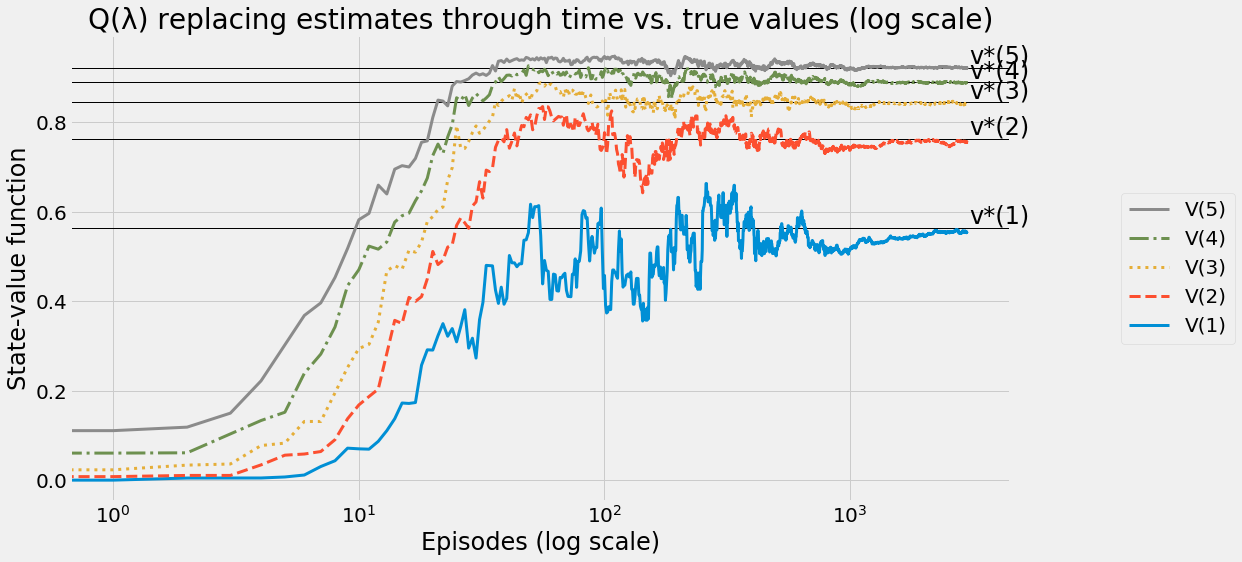

In [89]:
plot_value_function(
    'Q(λ) replacing estimates through time vs. true values (log scale)', 
    np.max(Q_track_rqll, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=True)

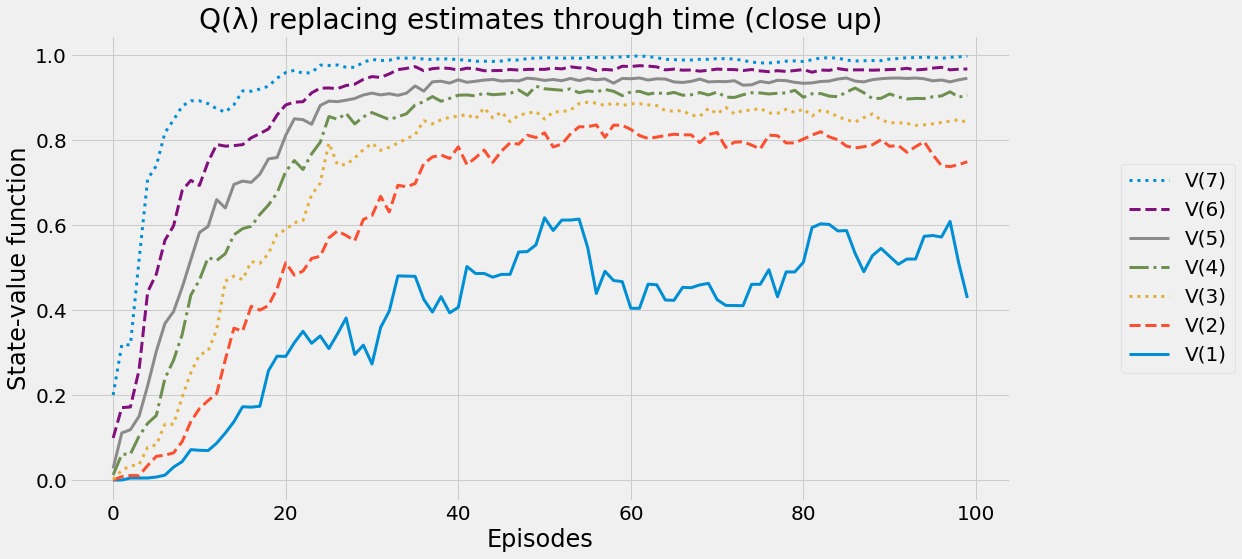

In [90]:
plot_value_function(
    'Q(λ) replacing estimates through time (close up)', 
    np.max(Q_track_rqll, axis=2)[:cu_episodes], 
    None,
    limit_items=cu_limit_items,
    limit_value=cu_limit_value,
    log=False)

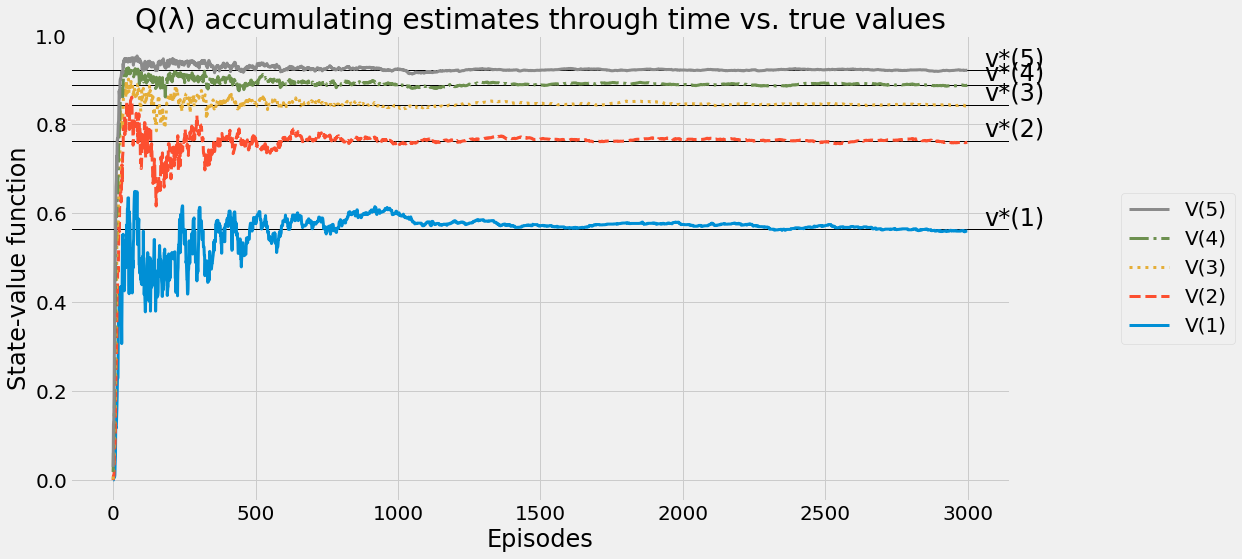

In [91]:
plot_value_function(
    'Q(λ) accumulating estimates through time vs. true values', 
    np.max(Q_track_aqll, axis=2), 
    optimal_V,
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)

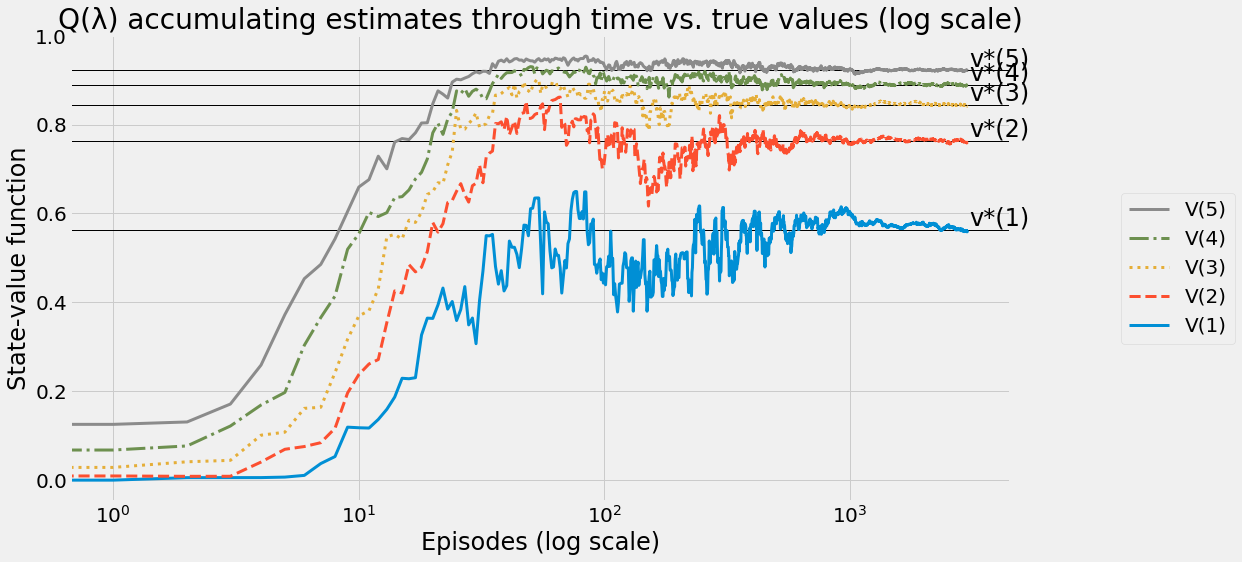

In [92]:
plot_value_function(
    'Q(λ) accumulating estimates through time vs. true values (log scale)', 
    np.max(Q_track_aqll, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=True)

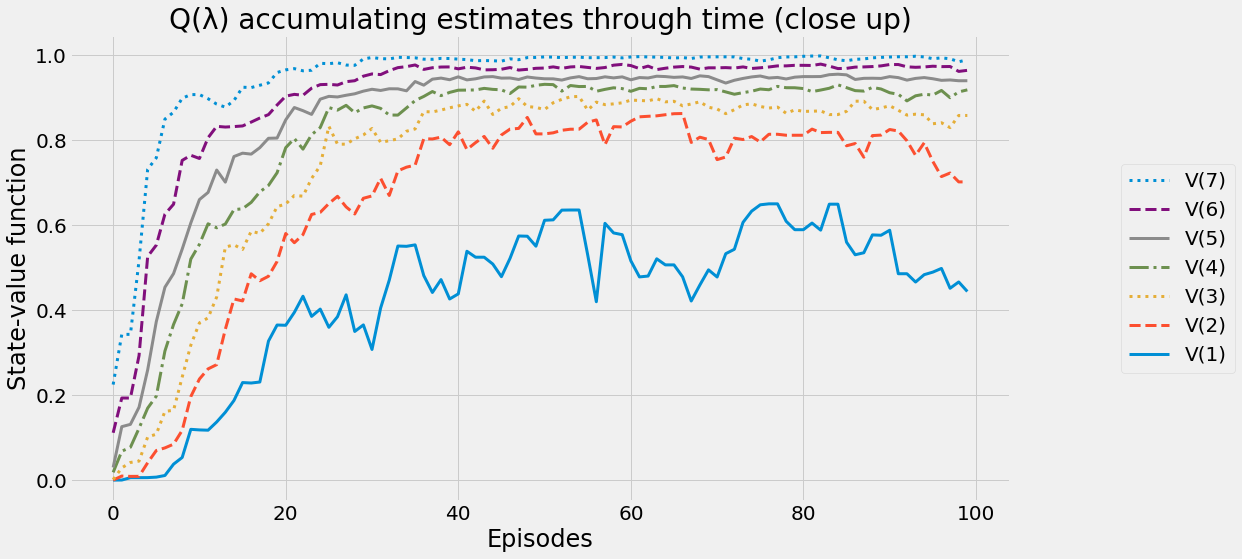

In [93]:
plot_value_function(
    'Q(λ) accumulating estimates through time (close up)', 
    np.max(Q_track_aqll, axis=2)[:cu_episodes], 
    None,
    limit_items=cu_limit_items,
    limit_value=cu_limit_value,
    log=False)

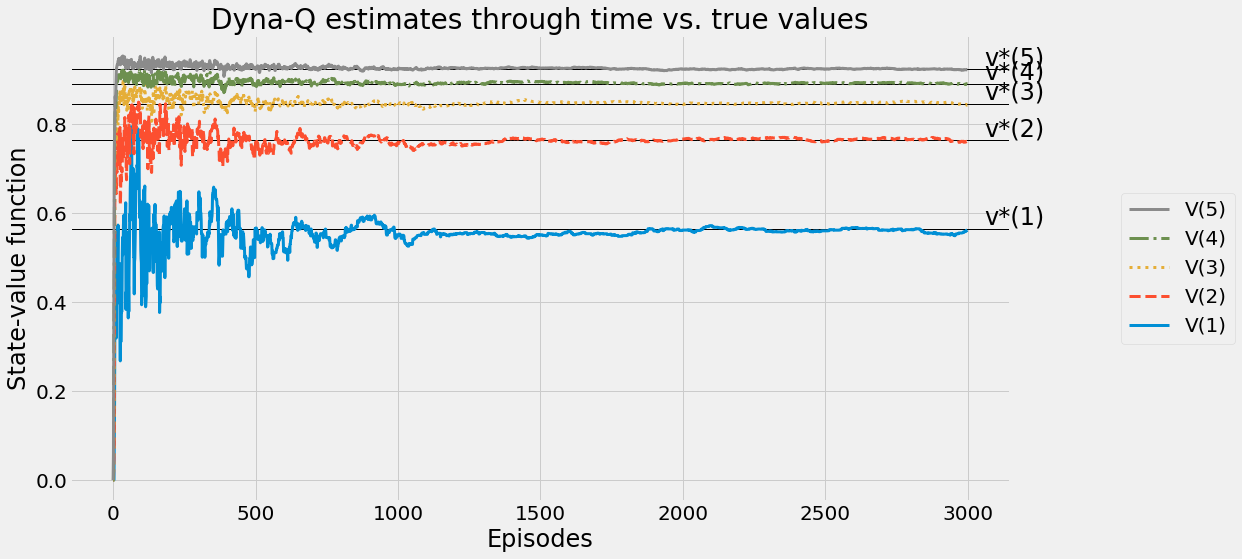

In [94]:
plot_value_function(
    'Dyna-Q estimates through time vs. true values', 
    np.max(Q_track_dq, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)

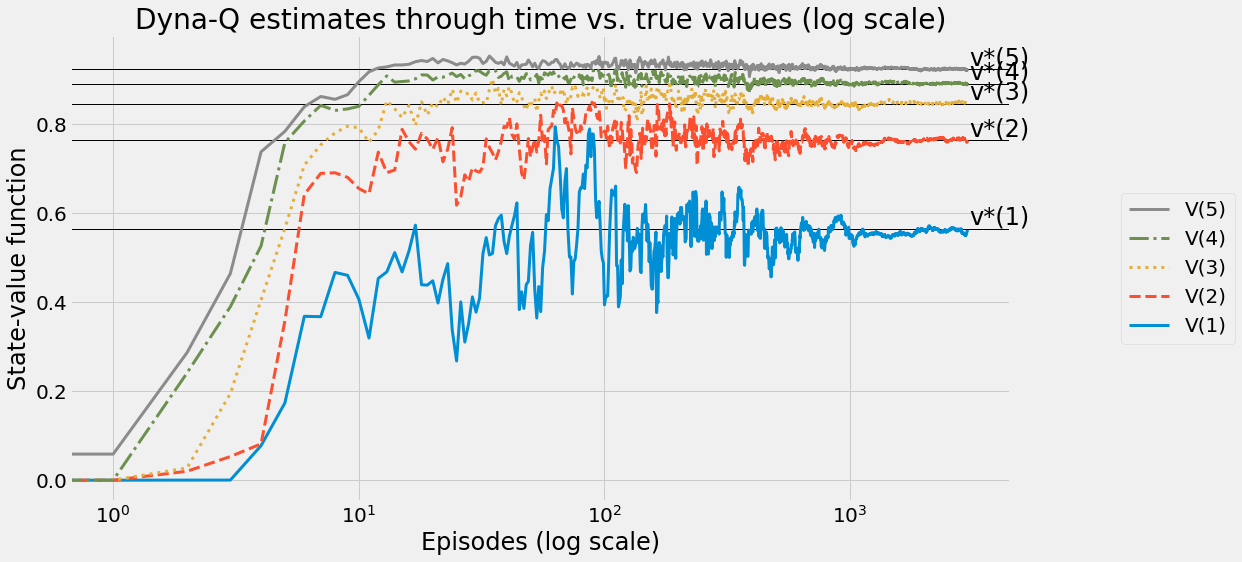

In [95]:
plot_value_function(
    'Dyna-Q estimates through time vs. true values (log scale)', 
    np.max(Q_track_dq, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=True)

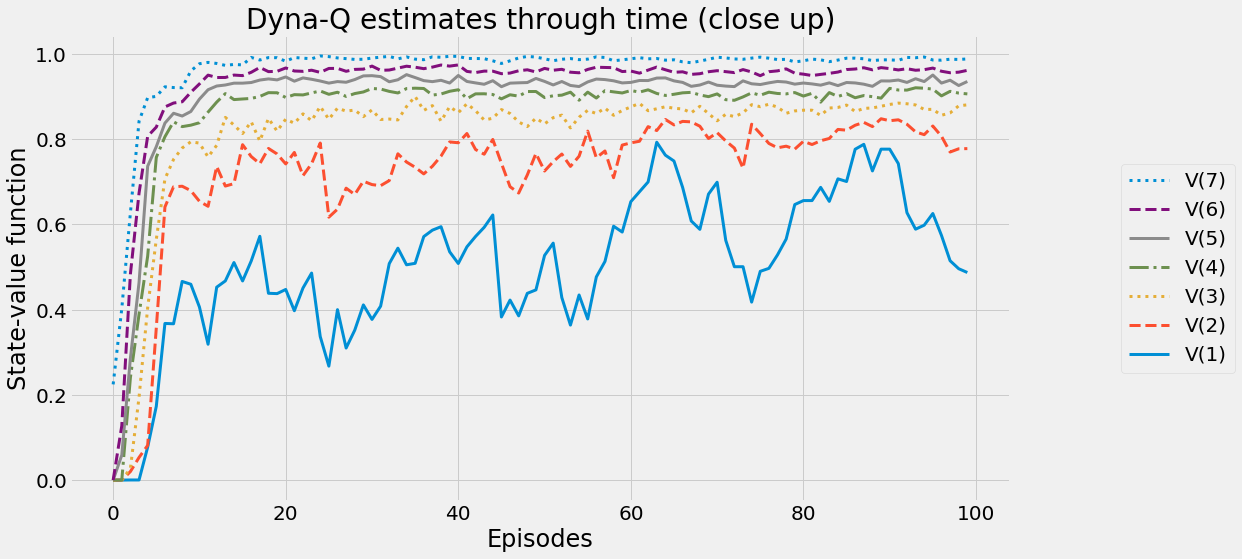

In [96]:
plot_value_function(
    'Dyna-Q estimates through time (close up)', 
    np.max(Q_track_dq, axis=2)[:cu_episodes], 
    None,
    limit_items=cu_limit_items,
    limit_value=cu_limit_value,
    log=False)

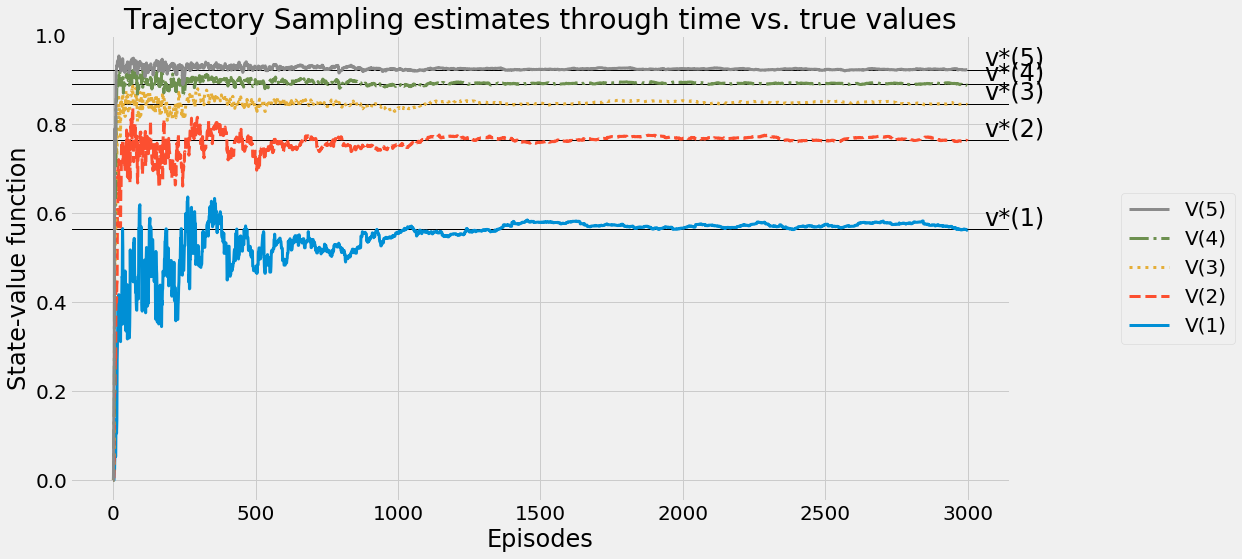

In [97]:
plot_value_function(
    'Trajectory Sampling estimates through time vs. true values', 
    np.max(Q_track_ts, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)

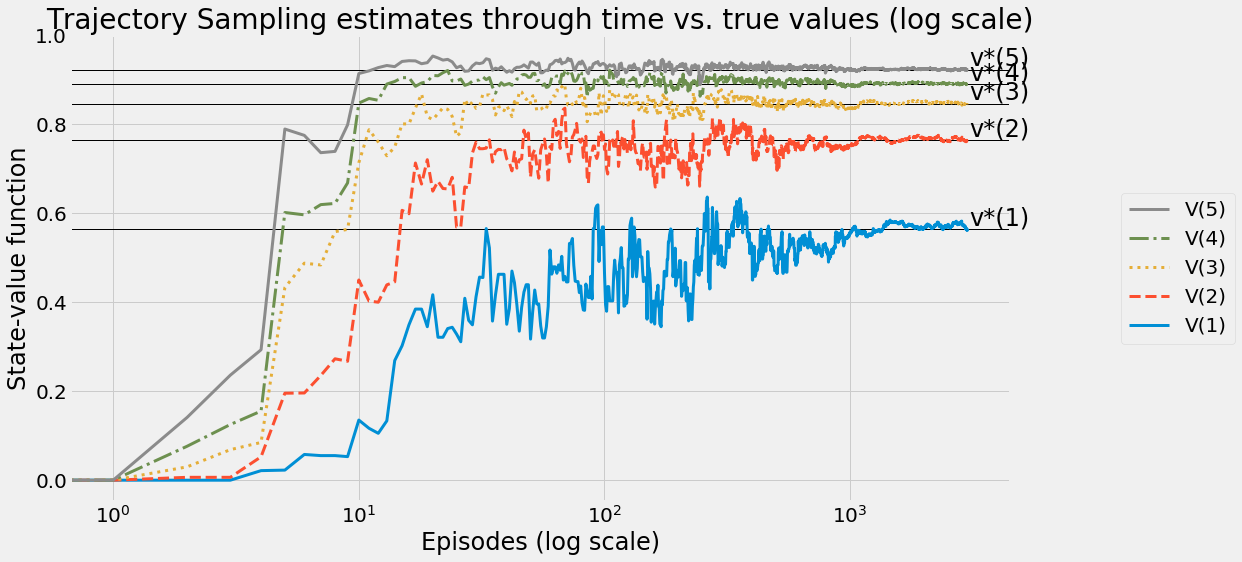

In [98]:
plot_value_function(
    'Trajectory Sampling estimates through time vs. true values (log scale)', 
    np.max(Q_track_ts, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=True)

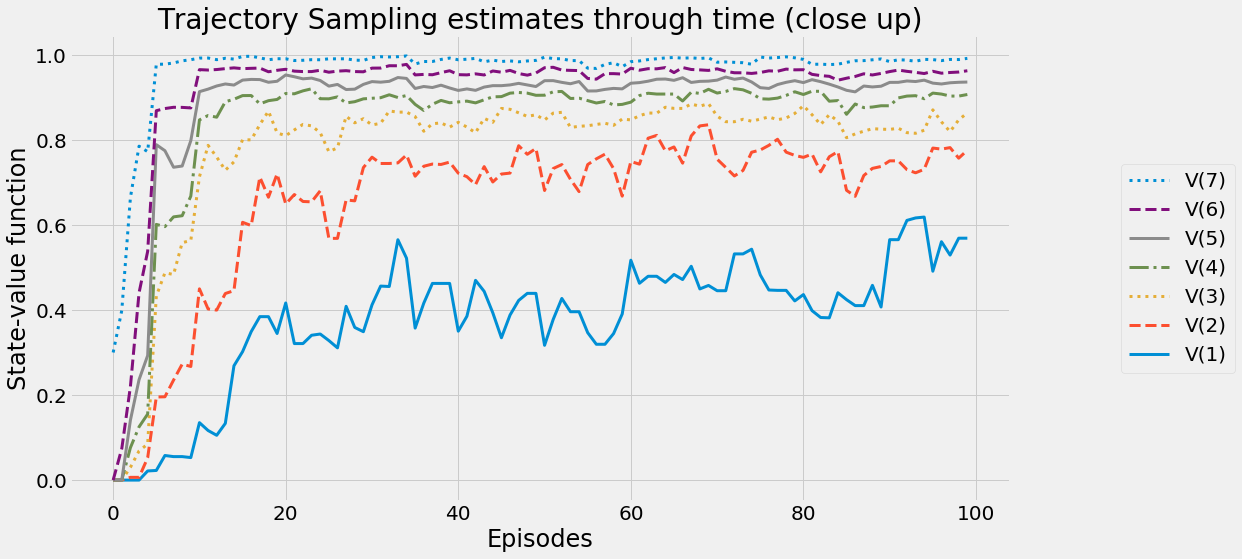

In [99]:
plot_value_function(
    'Trajectory Sampling estimates through time (close up)', 
    np.max(Q_track_ts, axis=2)[:cu_episodes], 
    None,
    limit_items=cu_limit_items,
    limit_value=cu_limit_value,
    log=False)

In [100]:
rsl_success_rate_ma, rsl_mean_return_ma, rsl_mean_regret_ma = get_metrics_from_tracks(
    env, gamma, goal_state, optimal_Q, pi_track_rsl)

In [101]:
asl_success_rate_ma, asl_mean_return_ma, asl_mean_regret_ma = get_metrics_from_tracks(
    env, gamma, goal_state, optimal_Q, pi_track_asl)

In [102]:
rqll_success_rate_ma, rqll_mean_return_ma, rqll_mean_regret_ma = get_metrics_from_tracks(
    env, gamma, goal_state, optimal_Q, pi_track_rqll)

In [103]:
aqll_success_rate_ma, aqll_mean_return_ma, aqll_mean_regret_ma = get_metrics_from_tracks(
    env, gamma, goal_state, optimal_Q, pi_track_aqll)

In [104]:
dq_success_rate_ma, dq_mean_return_ma, dq_mean_regret_ma = get_metrics_from_tracks(
    env, gamma, goal_state, optimal_Q, pi_track_dq)

In [105]:
ts_success_rate_ma, ts_mean_return_ma, ts_mean_regret_ma = get_metrics_from_tracks(
    env, gamma, goal_state, optimal_Q, pi_track_ts)

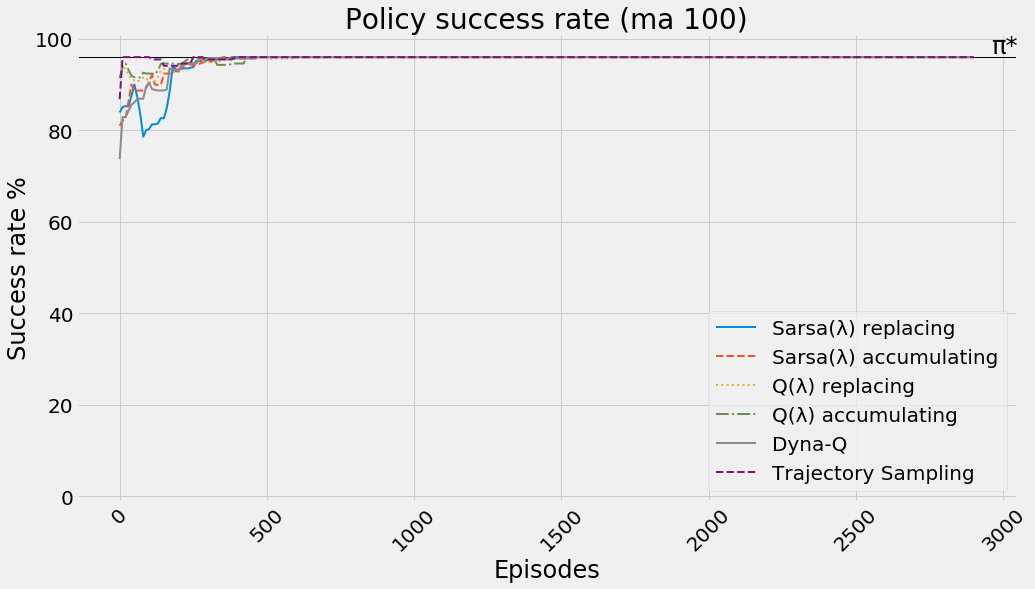

In [106]:
plt.axhline(y=success_rate_op, color='k', linestyle='-', linewidth=1)
plt.text(int(len(rsl_success_rate_ma)*1.02), success_rate_op*1.01, 'π*')

plt.plot(rsl_success_rate_ma, '-', linewidth=2, label='Sarsa(λ) replacing')
plt.plot(asl_success_rate_ma, '--', linewidth=2, label='Sarsa(λ) accumulating')
plt.plot(rqll_success_rate_ma, ':', linewidth=2, label='Q(λ) replacing')
plt.plot(aqll_success_rate_ma, '-.', linewidth=2, label='Q(λ) accumulating')
plt.plot(dq_success_rate_ma, '-', linewidth=2, label='Dyna-Q')
plt.plot(ts_success_rate_ma, '--', linewidth=2, label='Trajectory Sampling')
plt.legend(loc=4, ncol=1)

plt.title('Policy success rate (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Success rate %')
plt.ylim(-1, 101)
plt.xticks(rotation=45)


plt.show()

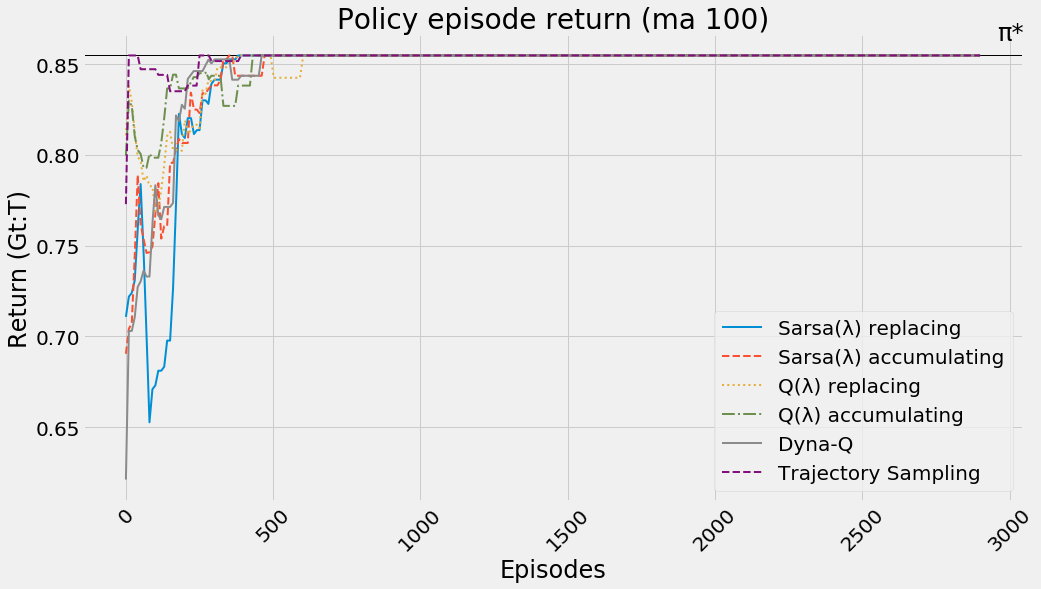

In [107]:
plt.axhline(y=mean_return_op, color='k', linestyle='-', linewidth=1)
plt.text(int(len(rsl_mean_return_ma)*1.02), mean_return_op*1.01, 'π*')

plt.plot(rsl_mean_return_ma, '-', linewidth=2, label='Sarsa(λ) replacing')
plt.plot(asl_mean_return_ma, '--', linewidth=2, label='Sarsa(λ) accumulating')
plt.plot(rqll_mean_return_ma, ':', linewidth=2, label='Q(λ) replacing')
plt.plot(aqll_mean_return_ma, '-.', linewidth=2, label='Q(λ) accumulating')
plt.plot(dq_mean_return_ma, '-', linewidth=2, label='Dyna-Q')
plt.plot(ts_mean_return_ma, '--', linewidth=2, label='Trajectory Sampling')
plt.legend(loc=4, ncol=1)

plt.title('Policy episode return (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Return (Gt:T)')

plt.xticks(rotation=45)

plt.show()

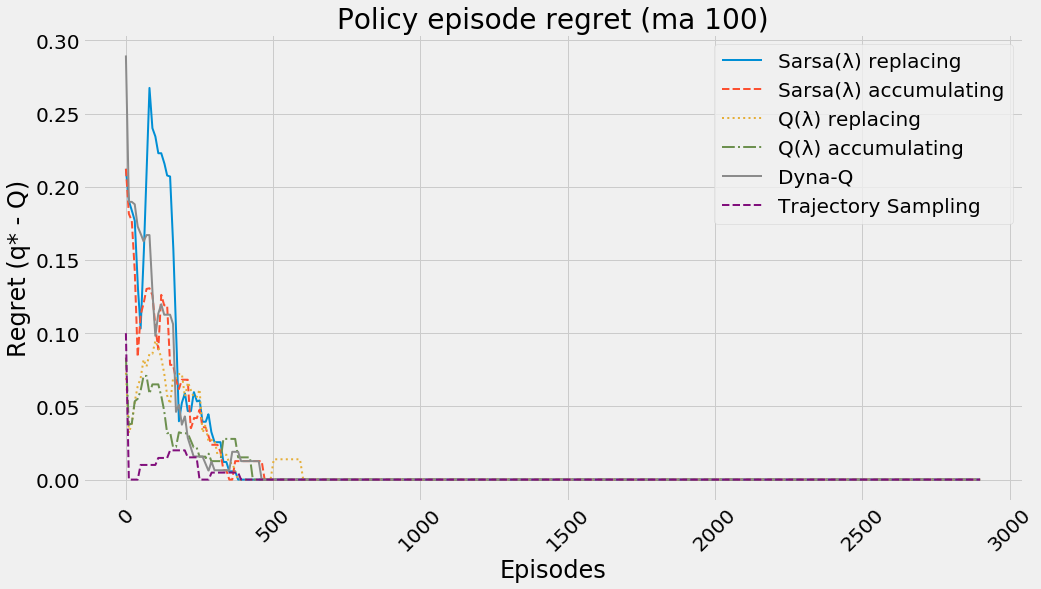

In [108]:
plt.plot(rsl_mean_regret_ma, '-', linewidth=2, label='Sarsa(λ) replacing')
plt.plot(asl_mean_regret_ma, '--', linewidth=2, label='Sarsa(λ) accumulating')
plt.plot(rqll_mean_regret_ma, ':', linewidth=2, label='Q(λ) replacing')
plt.plot(aqll_mean_regret_ma, '-.', linewidth=2, label='Q(λ) accumulating')
plt.plot(dq_mean_regret_ma, '-', linewidth=2, label='Dyna-Q')
plt.plot(ts_mean_regret_ma, '--', linewidth=2, label='Trajectory Sampling')
plt.legend(loc=1, ncol=1)

plt.title('Policy episode regret (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Regret (q* - Q)')
plt.xticks(rotation=45)

plt.show()

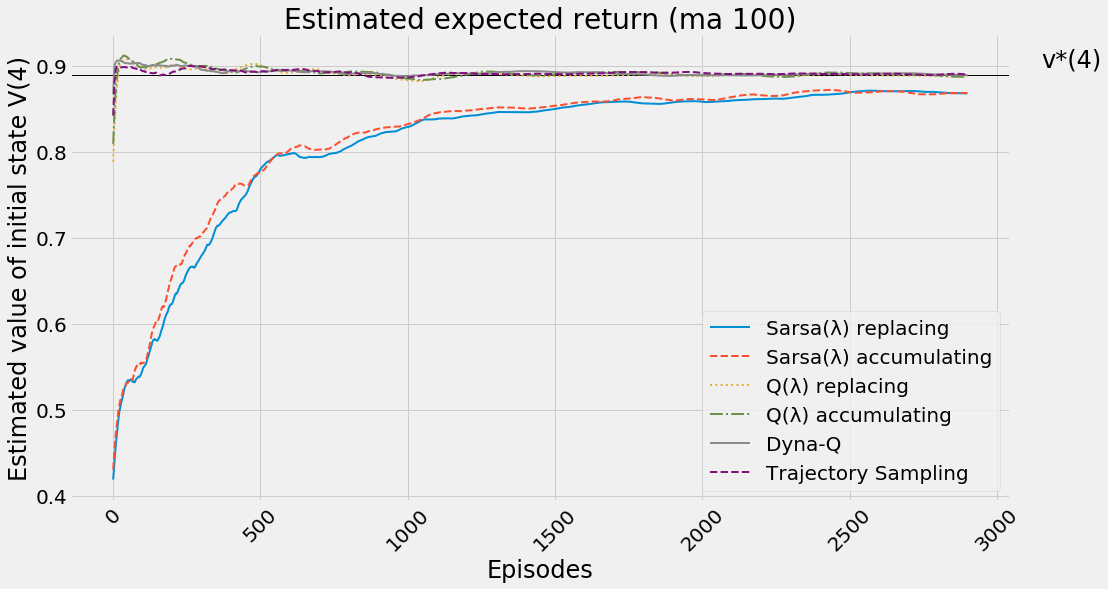

In [109]:
plt.axhline(y=optimal_V[init_state], color='k', linestyle='-', linewidth=1)
plt.text(int(len(Q_track_rsl)*1.05), optimal_V[init_state]+.01, 'v*({})'.format(init_state))

plt.plot(moving_average(np.max(Q_track_rsl, axis=2).T[init_state]), 
         '-', linewidth=2, label='Sarsa(λ) replacing')
plt.plot(moving_average(np.max(Q_track_asl, axis=2).T[init_state]), 
         '--', linewidth=2, label='Sarsa(λ) accumulating')
plt.plot(moving_average(np.max(Q_track_rqll, axis=2).T[init_state]), 
         ':', linewidth=2, label='Q(λ) replacing')
plt.plot(moving_average(np.max(Q_track_aqll, axis=2).T[init_state]), 
         '-.', linewidth=2, label='Q(λ) accumulating')
plt.plot(moving_average(np.max(Q_track_dq, axis=2).T[init_state]), 
         '-', linewidth=2, label='Dyna-Q')
plt.plot(moving_average(np.max(Q_track_ts, axis=2).T[init_state]), 
         '--', linewidth=2, label='Trajectory Sampling')
plt.legend(loc=4, ncol=1)

plt.title('Estimated expected return (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Estimated value of initial state V({})'.format(init_state))
plt.xticks(rotation=45)

plt.show()

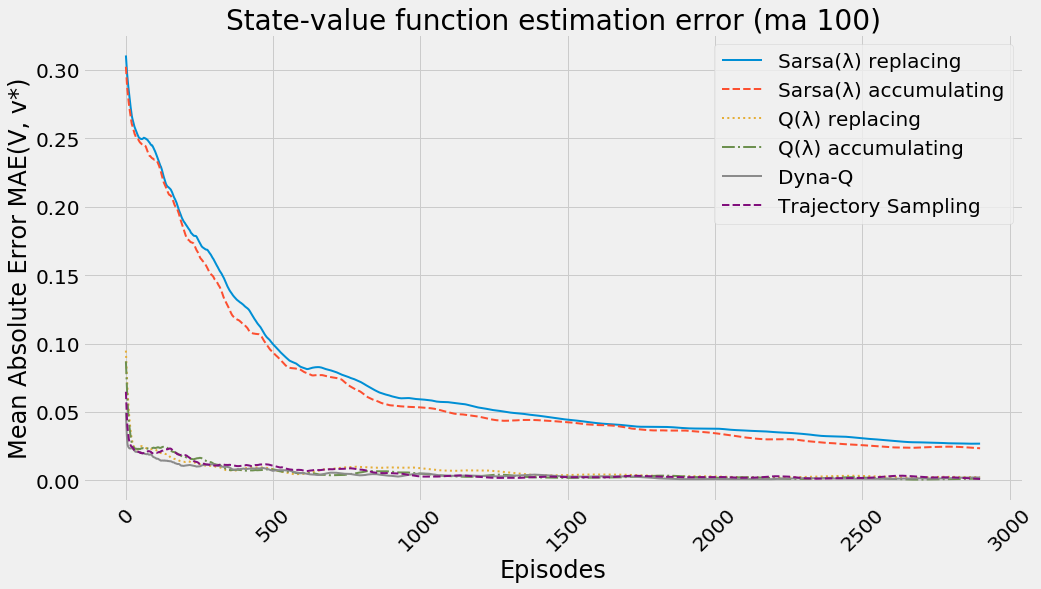

In [110]:
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_rsl, axis=2) - optimal_V), axis=1)), 
         '-', linewidth=2, label='Sarsa(λ) replacing')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_asl, axis=2) - optimal_V), axis=1)), 
         '--', linewidth=2, label='Sarsa(λ) accumulating')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_rqll, axis=2) - optimal_V), axis=1)), 
         ':', linewidth=2, label='Q(λ) replacing')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_aqll, axis=2) - optimal_V), axis=1)), 
         '-.', linewidth=2, label='Q(λ) accumulating')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_dq, axis=2) - optimal_V), axis=1)), 
         '-', linewidth=2, label='Dyna-Q')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_ts, axis=2) - optimal_V), axis=1)), 
         '--', linewidth=2, label='Trajectory Sampling')
plt.legend(loc=1, ncol=1)

plt.title('State-value function estimation error (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error MAE(V, v*)')
plt.xticks(rotation=45)

plt.show()

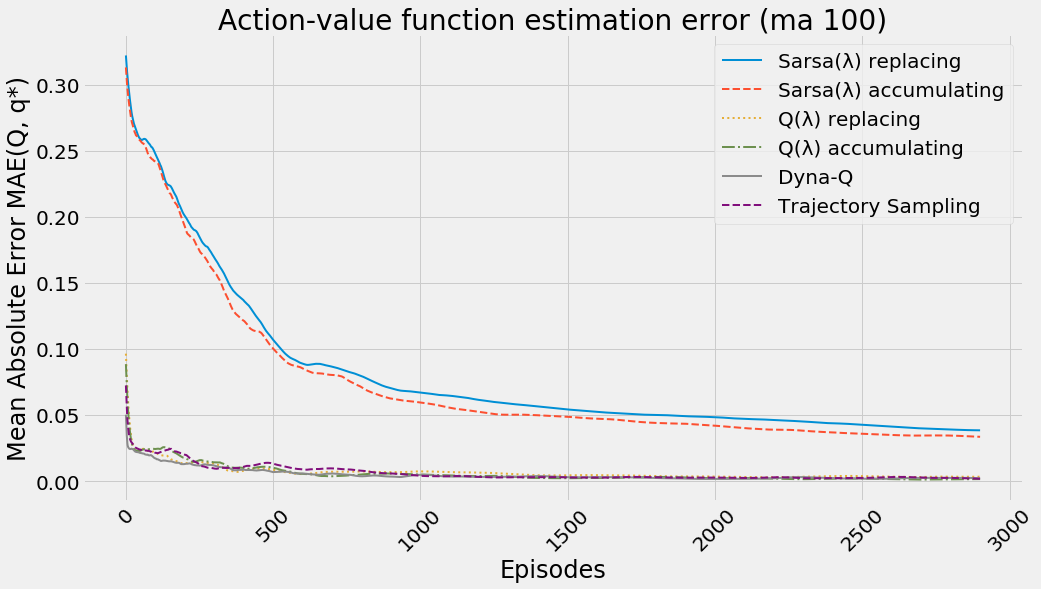

In [111]:
plt.plot(moving_average(np.mean(np.abs(Q_track_rsl - optimal_Q), axis=(1,2))), 
         '-', linewidth=2, label='Sarsa(λ) replacing')
plt.plot(moving_average(np.mean(np.abs(Q_track_asl - optimal_Q), axis=(1,2))), 
         '--', linewidth=2, label='Sarsa(λ) accumulating')
plt.plot(moving_average(np.mean(np.abs(Q_track_rqll - optimal_Q), axis=(1,2))), 
         ':', linewidth=2, label='Q(λ) replacing')
plt.plot(moving_average(np.mean(np.abs(Q_track_aqll - optimal_Q), axis=(1,2))), 
         '-.', linewidth=2, label='Q(λ) accumulating')
plt.plot(moving_average(np.mean(np.abs(Q_track_dq - optimal_Q), axis=(1,2))), 
         '-', linewidth=2, label='Dyna-Q')
plt.plot(moving_average(np.mean(np.abs(Q_track_ts - optimal_Q), axis=(1,2))), 
         '--', linewidth=2, label='Trajectory Sampling')
plt.legend(loc=1, ncol=1)

plt.title('Action-value function estimation error (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error MAE(Q, q*)')
plt.xticks(rotation=45)

plt.show()

In [112]:
env = gym.make('FrozenLake-v0')
init_state = env.reset()
goal_state = 15
gamma = 0.99
n_episodes = 10000
P = env.env.P
n_cols, svf_prec, err_prec, avf_prec=4, 4, 2, 3
action_symbols=('<', 'v', '>', '^')
limit_items, limit_value = 5, 0.0
cu_limit_items, cu_limit_value, cu_episodes = 10, 0.01, 2000

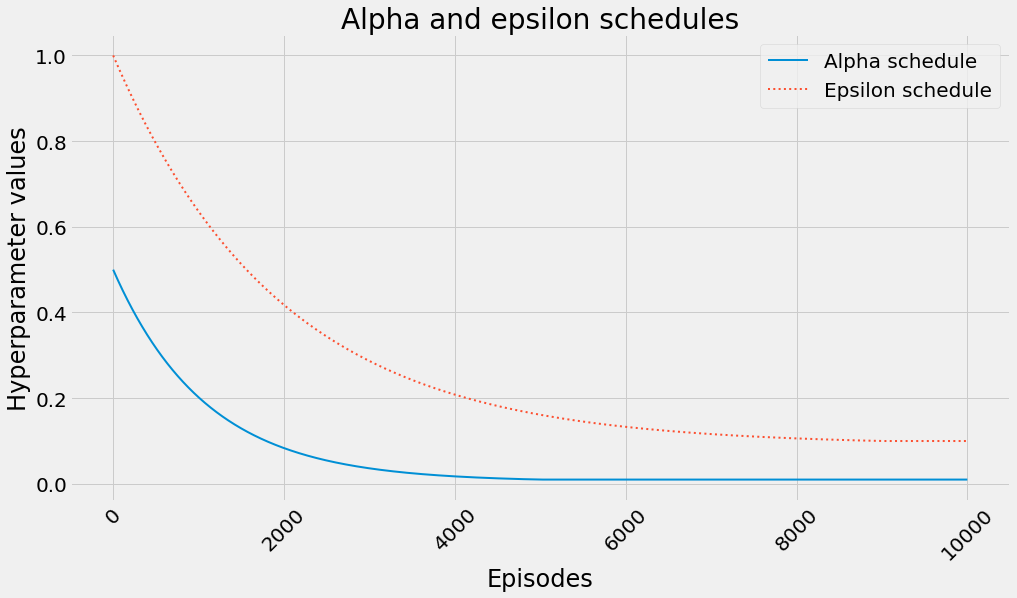

In [113]:
plt.plot(decay_schedule(0.5, 0.01, 0.5, n_episodes), 
         '-', linewidth=2, 
         label='Alpha schedule')
plt.plot(decay_schedule(1.0, 0.1, 0.9, n_episodes), 
         ':', linewidth=2, 
         label='Epsilon schedule')
plt.legend(loc=1, ncol=1)

plt.title('Alpha and epsilon schedules')
plt.xlabel('Episodes')
plt.ylabel('Hyperparameter values')
plt.xticks(rotation=45)

plt.show()

In [114]:
optimal_Q, optimal_V, optimal_pi = value_iteration(P, gamma=gamma)
print_state_value_function(optimal_V, P, n_cols=n_cols, prec=svf_prec, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Optimal action-value function:')
print()
print_policy(optimal_pi, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_op, mean_return_op, mean_regret_op = get_policy_metrics(
    env, gamma=gamma, pi=optimal_pi, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_op, mean_return_op, mean_regret_op))

Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 |
| 04 0.5585 |           | 06 0.3583 |           |
| 08 0.5918 | 09 0.6431 | 10 0.6152 |           |
|           | 13 0.7417 | 14 0.8628 |           |

Optimal action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╕
│   s │     < │     v │     > │     ^ │
╞═════╪═══════╪═══════╪═══════╪═══════╡
│   0 │ 0.542 │ 0.528 │ 0.528 │ 0.522 │
├─────┼───────┼───────┼───────┼───────┤
│   1 │ 0.343 │ 0.334 │ 0.32  │ 0.499 │
├─────┼───────┼───────┼───────┼───────┤
│   2 │ 0.438 │ 0.434 │ 0.424 │ 0.471 │
├─────┼───────┼───────┼───────┼───────┤
│   3 │ 0.306 │ 0.306 │ 0.302 │ 0.457 │
├─────┼───────┼───────┼───────┼───────┤
│   4 │ 0.558 │ 0.38  │ 0.374 │ 0.363 │
├─────┼───────┼───────┼───────┼───────┤
│   5 │ 0     │ 0     │ 0     │ 0     │
├─────┼───────┼───────┼───────┼───────┤
│   6 │ 0.358 │ 0.203 │ 0.358 │ 0.155 │
├─────┼───────┼───────┼───────┼───────┤
│   7 │ 0     │ 0     │ 0     │ 0     │
├─────┼───────┼───

In [115]:
Q_rsls, V_rsls, Q_track_rsls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_rsl, V_rsl, pi_rsl, Q_track_rsl, pi_track_rsl = sarsa_lambda(env, gamma=gamma, n_episodes=n_episodes)
    Q_rsls.append(Q_rsl) ; V_rsls.append(V_rsl) ; Q_track_rsls.append(Q_track_rsl)
Q_rsl, V_rsl, Q_track_rsl = np.mean(Q_rsls, axis=0), np.mean(V_rsls, axis=0), np.mean(Q_track_rsls, axis=0)
del Q_rsls ; del V_rsls ; del Q_track_rsls

In [116]:
print_state_value_function(V_rsl, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Sarsa(λ) replacing:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_rsl - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_rsl, optimal_V)))
print()
print_action_value_function(Q_rsl, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Sarsa(λ) replacing action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_rsl, optimal_Q)))
print()
print_policy(pi_rsl, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_rsl, mean_return_rsl, mean_regret_rsl = get_policy_metrics(
    env, gamma=gamma, pi=pi_rsl, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_rsl, mean_return_rsl, mean_regret_rsl))

State-value function found by Sarsa(λ) replacing:
| 00 0.2941 | 01 0.2414 | 02 0.2168 | 03  0.133 |
| 04 0.3138 |           | 06 0.2152 |           |
| 08 0.3585 | 09 0.4465 | 10 0.4496 |           |
|           | 13 0.5839 | 14 0.7726 |           |
Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 |
| 04 0.5585 |           | 06 0.3583 |           |
| 08 0.5918 | 09 0.6431 | 10 0.6152 |           |
|           | 13 0.7417 | 14 0.8628 |           |
State-value function errors:
| 00  -0.25 | 01  -0.26 | 02  -0.25 | 03  -0.32 |
| 04  -0.24 |           | 06  -0.14 |           |
| 08  -0.23 | 09   -0.2 | 10  -0.17 |           |
|           | 13  -0.16 | 14  -0.09 |           |
State-value function RMSE: 0.1822

Sarsa(λ) replacing action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │ 

In [117]:
Q_asls, V_asls, Q_track_asls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_asl, V_asl, pi_asl, Q_track_asl, pi_track_asl = sarsa_lambda(env, gamma=gamma, 
                                                                   replacing_traces=False, 
                                                                   n_episodes=n_episodes)
    Q_asls.append(Q_asl) ; V_asls.append(V_asl) ; Q_track_asls.append(Q_track_asl)
Q_asl, V_asl, Q_track_asl = np.mean(Q_asls, axis=0), np.mean(V_asls, axis=0), np.mean(Q_track_asls, axis=0)
del Q_asls ; del V_asls ; del Q_track_asls

In [118]:
print_state_value_function(V_asl, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Sarsa(λ) accumulating:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_asl - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_asl, optimal_V)))
print()
print_action_value_function(Q_asl, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Sarsa(λ) accumulating action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_asl, optimal_Q)))
print()
print_policy(pi_asl, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_asl, mean_return_asl, mean_regret_asl = get_policy_metrics(
    env, gamma=gamma, pi=pi_asl, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_asl, mean_return_asl, mean_regret_asl))

State-value function found by Sarsa(λ) accumulating:
| 00 0.2872 | 01 0.2453 | 02 0.2138 | 03 0.1526 |
| 04 0.3114 |           | 06 0.2142 |           |
| 08 0.3617 | 09 0.4517 | 10 0.4699 |           |
|           | 13 0.5917 | 14 0.7812 |           |
Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 |
| 04 0.5585 |           | 06 0.3583 |           |
| 08 0.5918 | 09 0.6431 | 10 0.6152 |           |
|           | 13 0.7417 | 14 0.8628 |           |
State-value function errors:
| 00  -0.25 | 01  -0.25 | 02  -0.26 | 03   -0.3 |
| 04  -0.25 |           | 06  -0.14 |           |
| 08  -0.23 | 09  -0.19 | 10  -0.15 |           |
|           | 13  -0.15 | 14  -0.08 |           |
State-value function RMSE: 0.1784

Sarsa(λ) accumulating action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   er

In [119]:
Q_rqlls, V_rqlls, Q_track_rqlls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_rqll, V_rqll, pi_rqll, Q_track_rqll, pi_track_rqll = q_lambda(env, gamma=gamma, n_episodes=n_episodes)
    Q_rqlls.append(Q_rqll) ; V_rqlls.append(V_rqll) ; Q_track_rqlls.append(Q_track_rqll)
Q_rqll, V_rqll, Q_track_rqll = np.mean(Q_rqlls, axis=0), np.mean(V_rqlls, axis=0), np.mean(Q_track_rqlls, axis=0)
del Q_rqlls ; del V_rqlls ; del Q_track_rqlls

In [120]:
print_state_value_function(V_rqll, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Q(λ) replacing:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_rqll - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_rqll, optimal_V)))
print()
print_action_value_function(Q_rqll, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Q(λ) replacing action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_rqll, optimal_Q)))
print()
print_policy(pi_rqll, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_rqll, mean_return_rqll, mean_regret_rqll = get_policy_metrics(
    env, gamma=gamma, pi=pi_rqll, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_rqll, mean_return_rqll, mean_regret_rqll))

State-value function found by Q(λ) replacing:
| 00 0.5212 | 01 0.4765 | 02 0.4481 | 03 0.4323 |
| 04 0.5374 |           | 06 0.3374 |           |
| 08 0.5717 | 09 0.6193 | 10 0.5863 |           |
|           | 13 0.7289 | 14 0.8544 |           |
Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 |
| 04 0.5585 |           | 06 0.3583 |           |
| 08 0.5918 | 09 0.6431 | 10 0.6152 |           |
|           | 13 0.7417 | 14 0.8628 |           |
State-value function errors:
| 00  -0.02 | 01  -0.02 | 02  -0.02 | 03  -0.02 |
| 04  -0.02 |           | 06  -0.02 |           |
| 08  -0.02 | 09  -0.02 | 10  -0.03 |           |
|           | 13  -0.01 | 14  -0.01 |           |
State-value function RMSE: 0.0176

Q(λ) replacing action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ 

In [121]:
Q_aqlls, V_aqlls, Q_track_aqlls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_aqll, V_aqll, pi_aqll, Q_track_aqll, pi_track_aqll = q_lambda(env, gamma=gamma, 
                                                                    replacing_traces=False,
                                                                    n_episodes=n_episodes)
    Q_aqlls.append(Q_aqll) ; V_aqlls.append(V_aqll) ; Q_track_aqlls.append(Q_track_aqll)
Q_aqll, V_aqll, Q_track_aqll = np.mean(Q_aqlls, axis=0), np.mean(V_aqlls, axis=0), np.mean(Q_track_aqlls, axis=0)
del Q_aqlls ; del V_aqlls ; del Q_track_aqlls

In [122]:
print_state_value_function(V_aqll, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Q(λ) accumulating:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_aqll - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_aqll, optimal_V)))
print()
print_action_value_function(Q_aqll, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Q(λ) accumulating action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_aqll, optimal_Q)))
print()
print_policy(pi_aqll, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_aqll, mean_return_aqll, mean_regret_aqll = get_policy_metrics(
    env, gamma=gamma, pi=pi_aqll, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_aqll, mean_return_aqll, mean_regret_aqll))

State-value function found by Q(λ) accumulating:
| 00 0.5216 | 01 0.4812 | 02 0.4512 | 03 0.4371 |
| 04 0.5401 |           | 06 0.3409 |           |
| 08 0.5803 | 09 0.6333 | 10 0.6114 |           |
|           | 13 0.7333 | 14 0.8656 |           |
Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 |
| 04 0.5585 |           | 06 0.3583 |           |
| 08 0.5918 | 09 0.6431 | 10 0.6152 |           |
|           | 13 0.7417 | 14 0.8628 |           |
State-value function errors:
| 00  -0.02 | 01  -0.02 | 02  -0.02 | 03  -0.02 |
| 04  -0.02 |           | 06  -0.02 |           |
| 08  -0.01 | 09  -0.01 | 10   -0.0 |           |
|           | 13  -0.01 | 14    0.0 |           |
State-value function RMSE: 0.0124

Q(λ) accumulating action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   

In [123]:
Q_dqs, V_dqs, Q_track_dqs = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_dq, V_dq, pi_dq, Q_track_dq, pi_track_dq, T_track_dq, R_track_dq, planning_dq = dyna_q(
        env, gamma=gamma, n_episodes=n_episodes)
    Q_dqs.append(Q_dq) ; V_dqs.append(V_dq) ; Q_track_dqs.append(Q_track_dq)
Q_dq, V_dq, Q_track_dq = np.mean(Q_dqs, axis=0), np.mean(V_dqs, axis=0), np.mean(Q_track_dqs, axis=0)
del Q_dqs ; del V_dqs ; del Q_track_dqs

In [124]:
print_state_value_function(V_dq, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Dyna-Q:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_dq - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_dq, optimal_V)))
print()
print_action_value_function(Q_dq, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Dyna-Q action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_dq, optimal_Q)))
print()
print_policy(pi_dq, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_dq, mean_return_dq, mean_regret_dq = get_policy_metrics(
    env, gamma=gamma, pi=pi_dq, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_dq, mean_return_dq, mean_regret_dq))

State-value function found by Dyna-Q:
| 00 0.5361 | 01 0.4911 | 02 0.4617 | 03  0.447 |
| 04 0.5538 |           | 06 0.3693 |           |
| 08 0.5889 | 09 0.6454 | 10 0.6198 |           |
|           | 13 0.7425 | 14 0.8712 |           |
Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 |
| 04 0.5585 |           | 06 0.3583 |           |
| 08 0.5918 | 09 0.6431 | 10 0.6152 |           |
|           | 13 0.7417 | 14 0.8628 |           |
State-value function errors:
| 00  -0.01 | 01  -0.01 | 02  -0.01 | 03  -0.01 |
| 04   -0.0 |           | 06   0.01 |           |
| 08   -0.0 | 09    0.0 | 10    0.0 |           |
|           | 13    0.0 | 14   0.01 |           |
State-value function RMSE: 0.0057

Dyna-Q action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪═══════